---
# <div align="center"><font color='green'> COSC 2673/2793 |  Machine Learning | Assignment 1 </font></div>
## <div align="center"> <font color='red'> Student Name: Shreyas Shah                              </font></div>
## <div align="center"> <font color='red'> Student number: s4005805                            </font></div>
---

# Problem statement

The goal of this project is to develop regression models that predict two target variables from the provided dataset, 
- TARGET_Capacity - The chatbot’s capacity in terms of the length of meaningful conversation.
- TARGET_CaseCount - The number of AI tasks that can be run in parallel.

To do this, the dataset will be split into training, validation and testing subsets. Exploratory Data Analysis (EDA) will first be performed to understand feature distributions and relationships with the target variables.

The data will then be pre-processed using transformations and scaling methods, followed by the development of:
- Linear Regression models (baseline and advanced),
- Polynomial Regression models (baseline and advanced),
- Poisson Regression models (baseline and advanced) for count-based prediction.

Each model will be evaluated using appropriate performance metrics. Feature selection, regularisation, and PCA will be applied where needed to improve performance and reduce complexity. The models will be compared using the test dataset and the best-performing models for each target will be selected for final predictions on the evaluation set.


## Data Splitting, and EDA

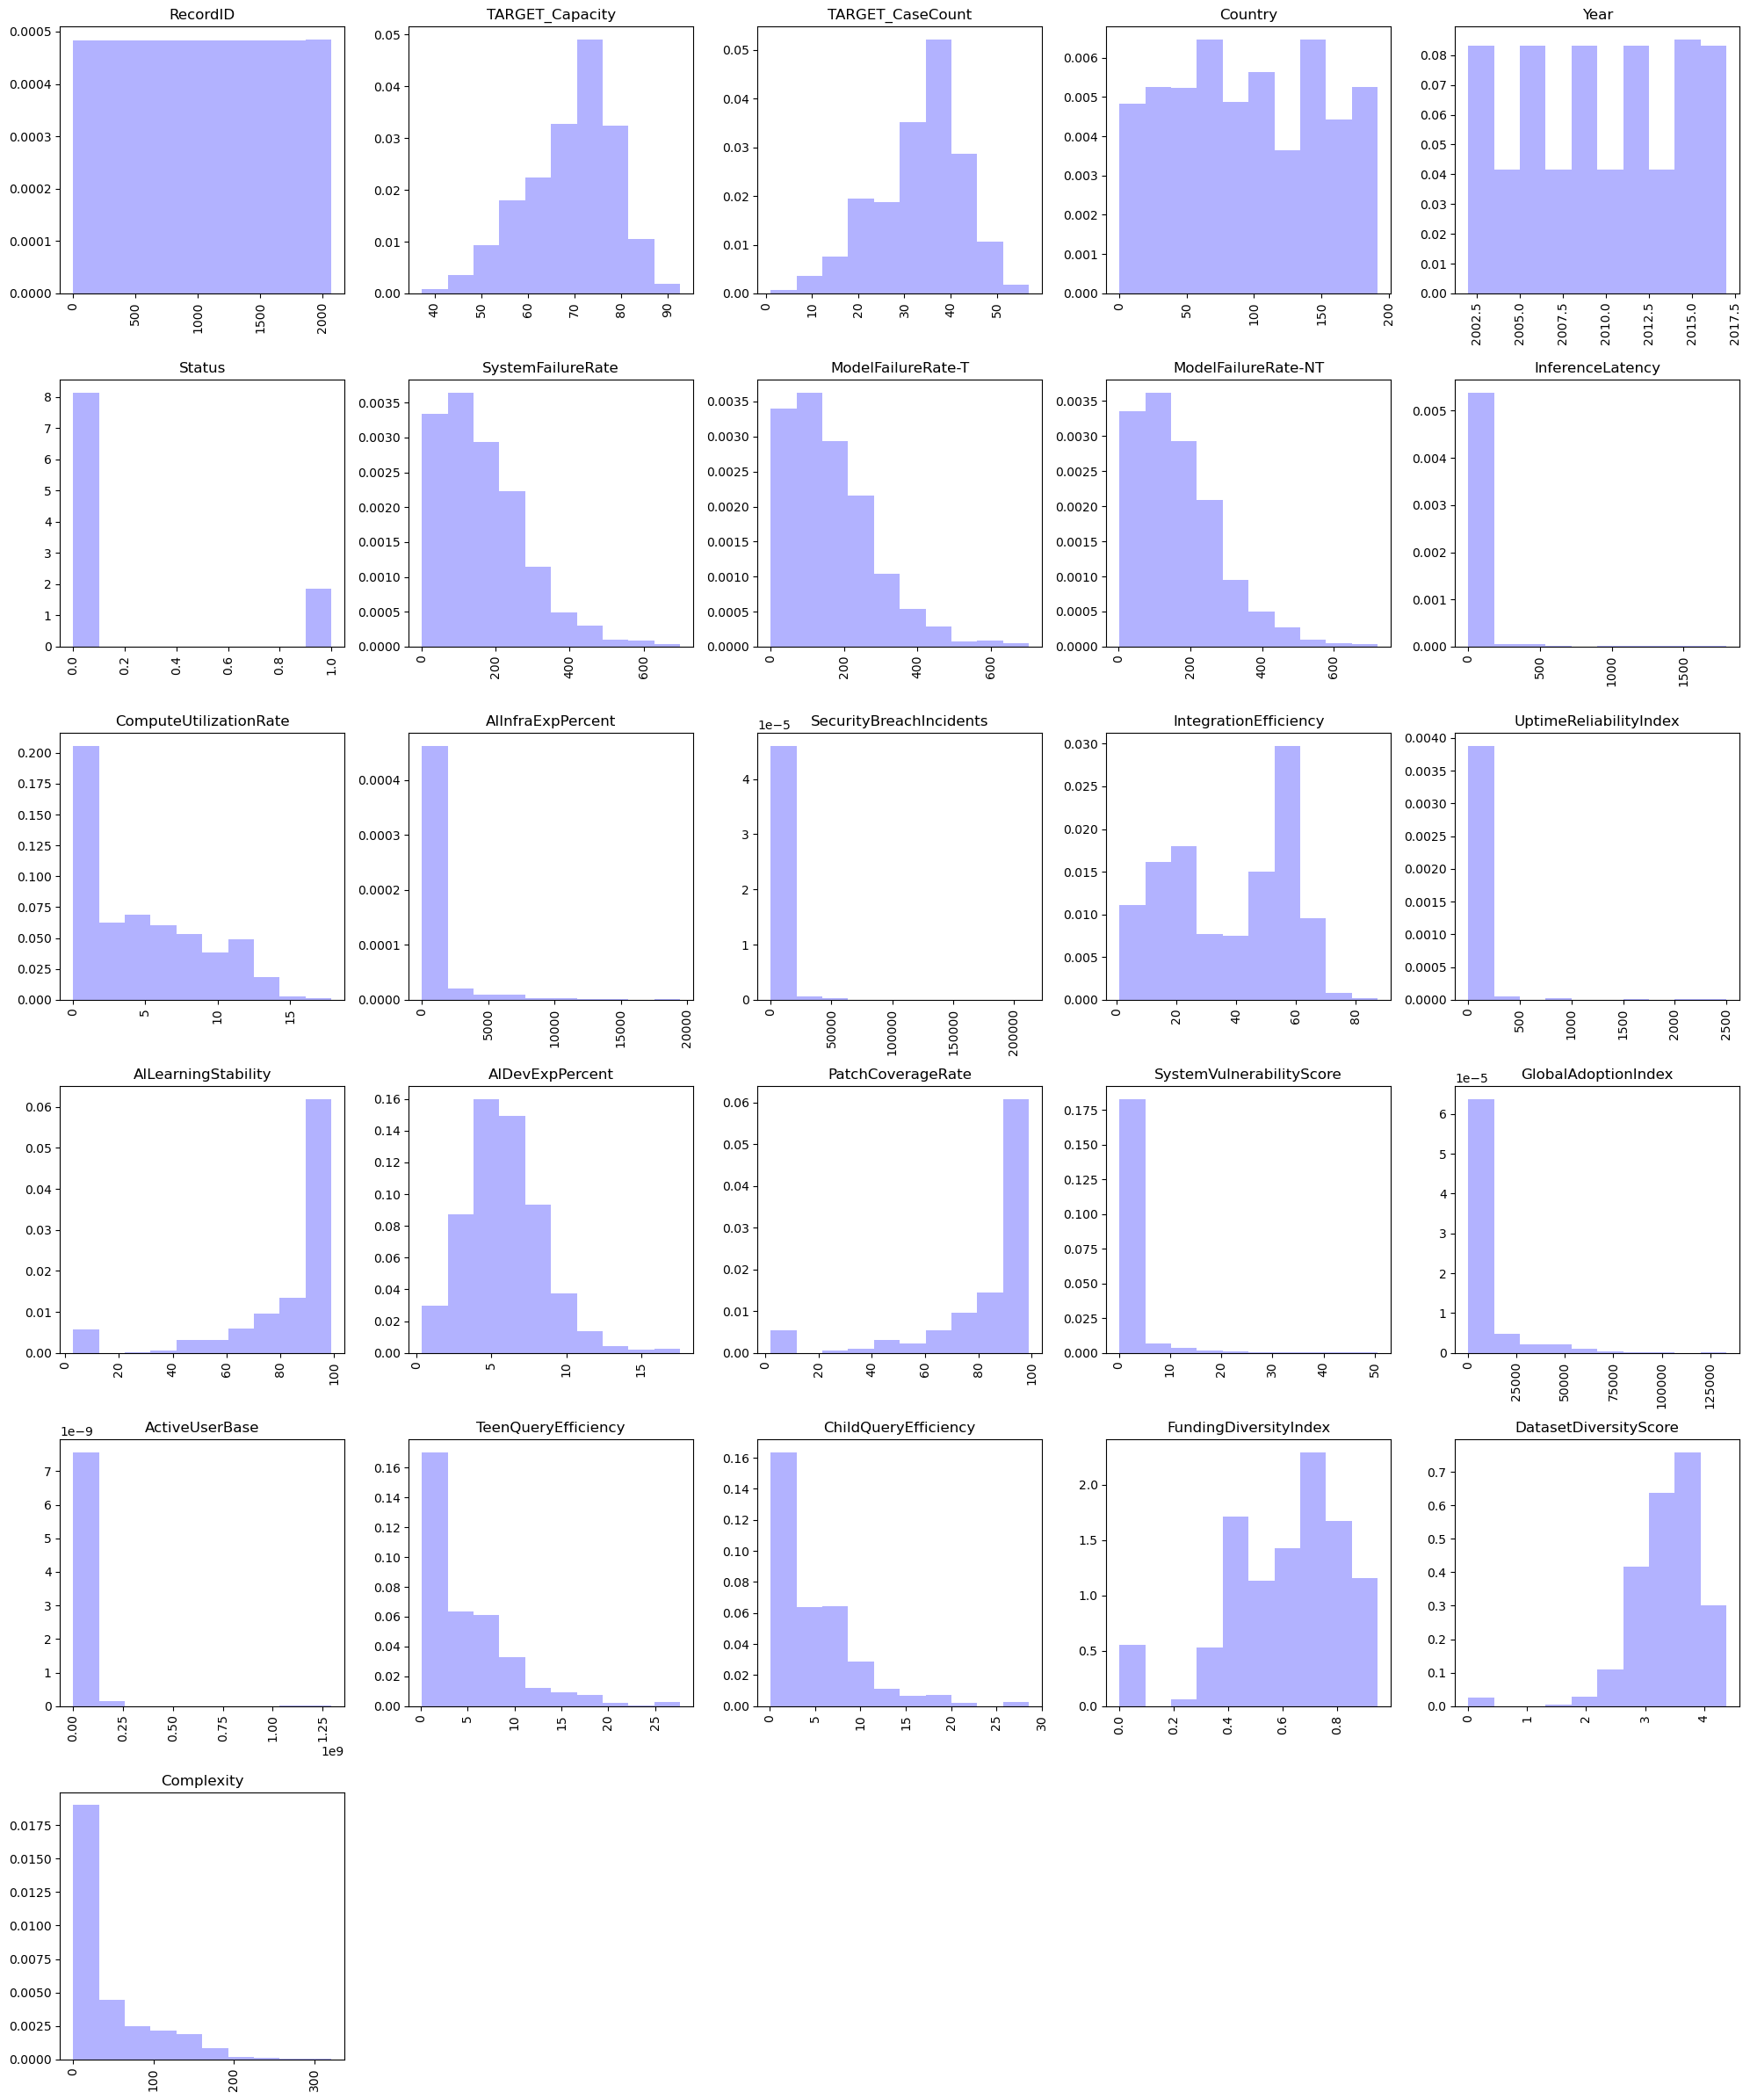

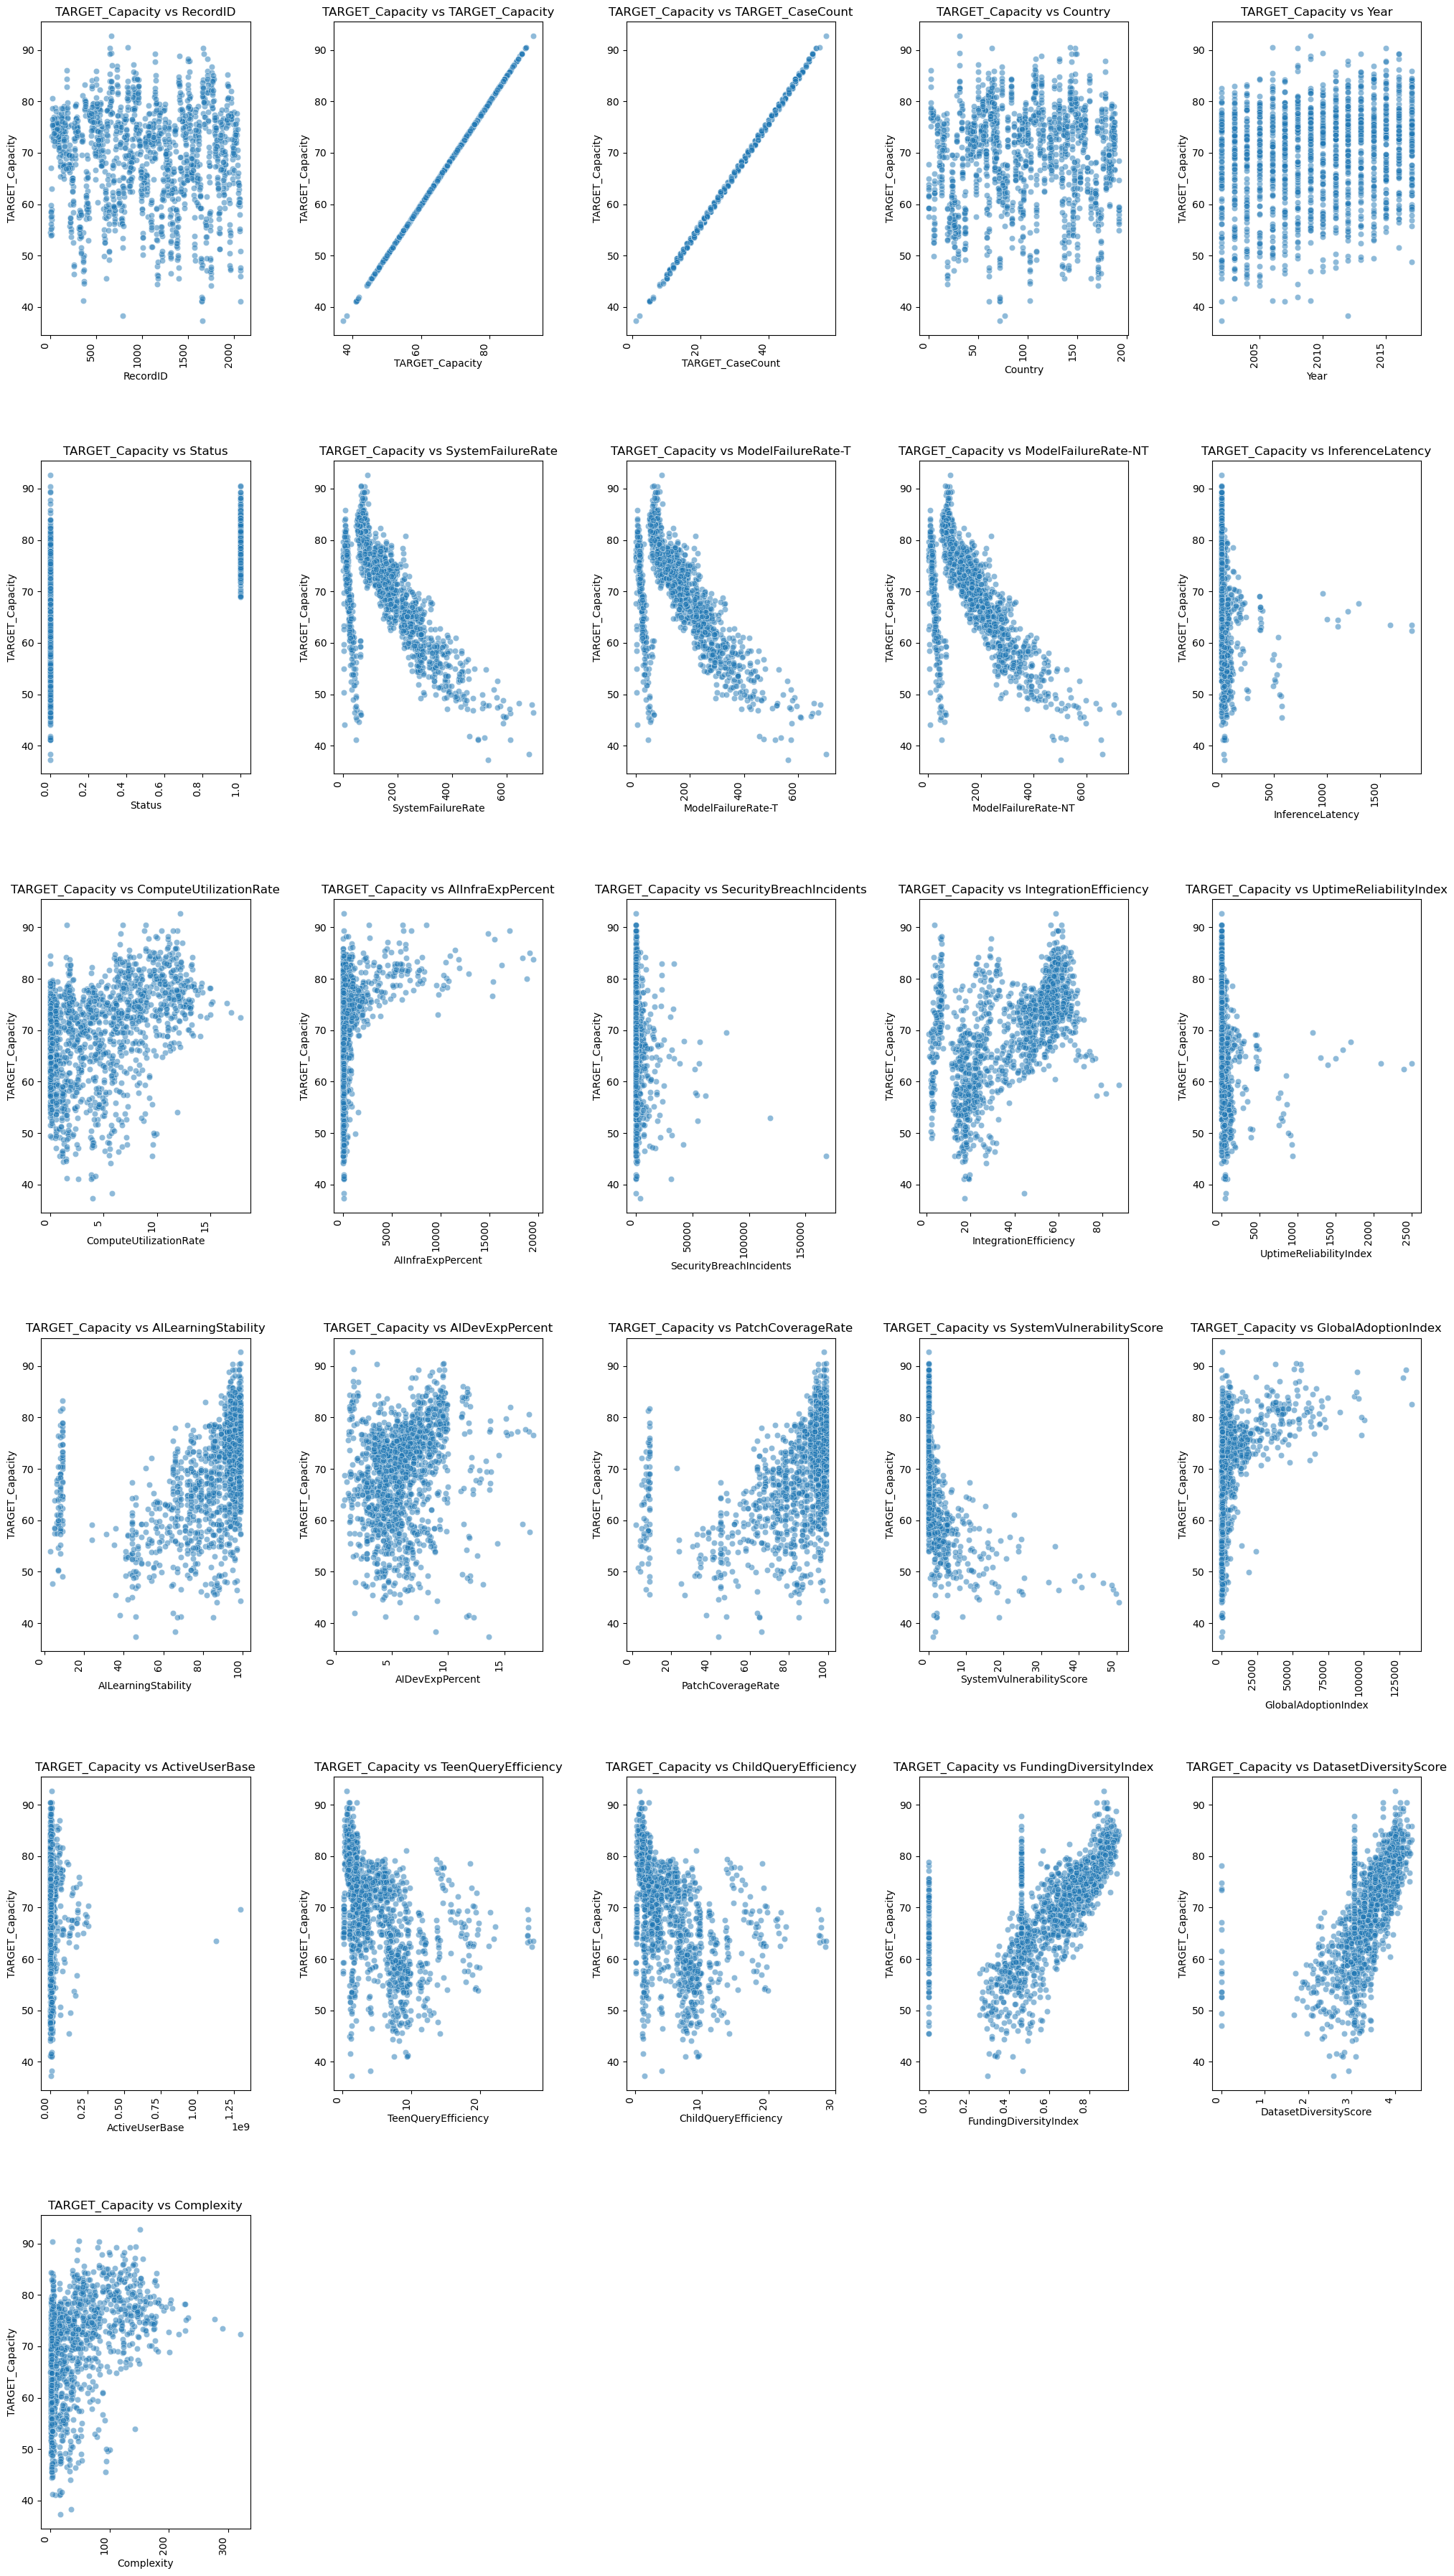

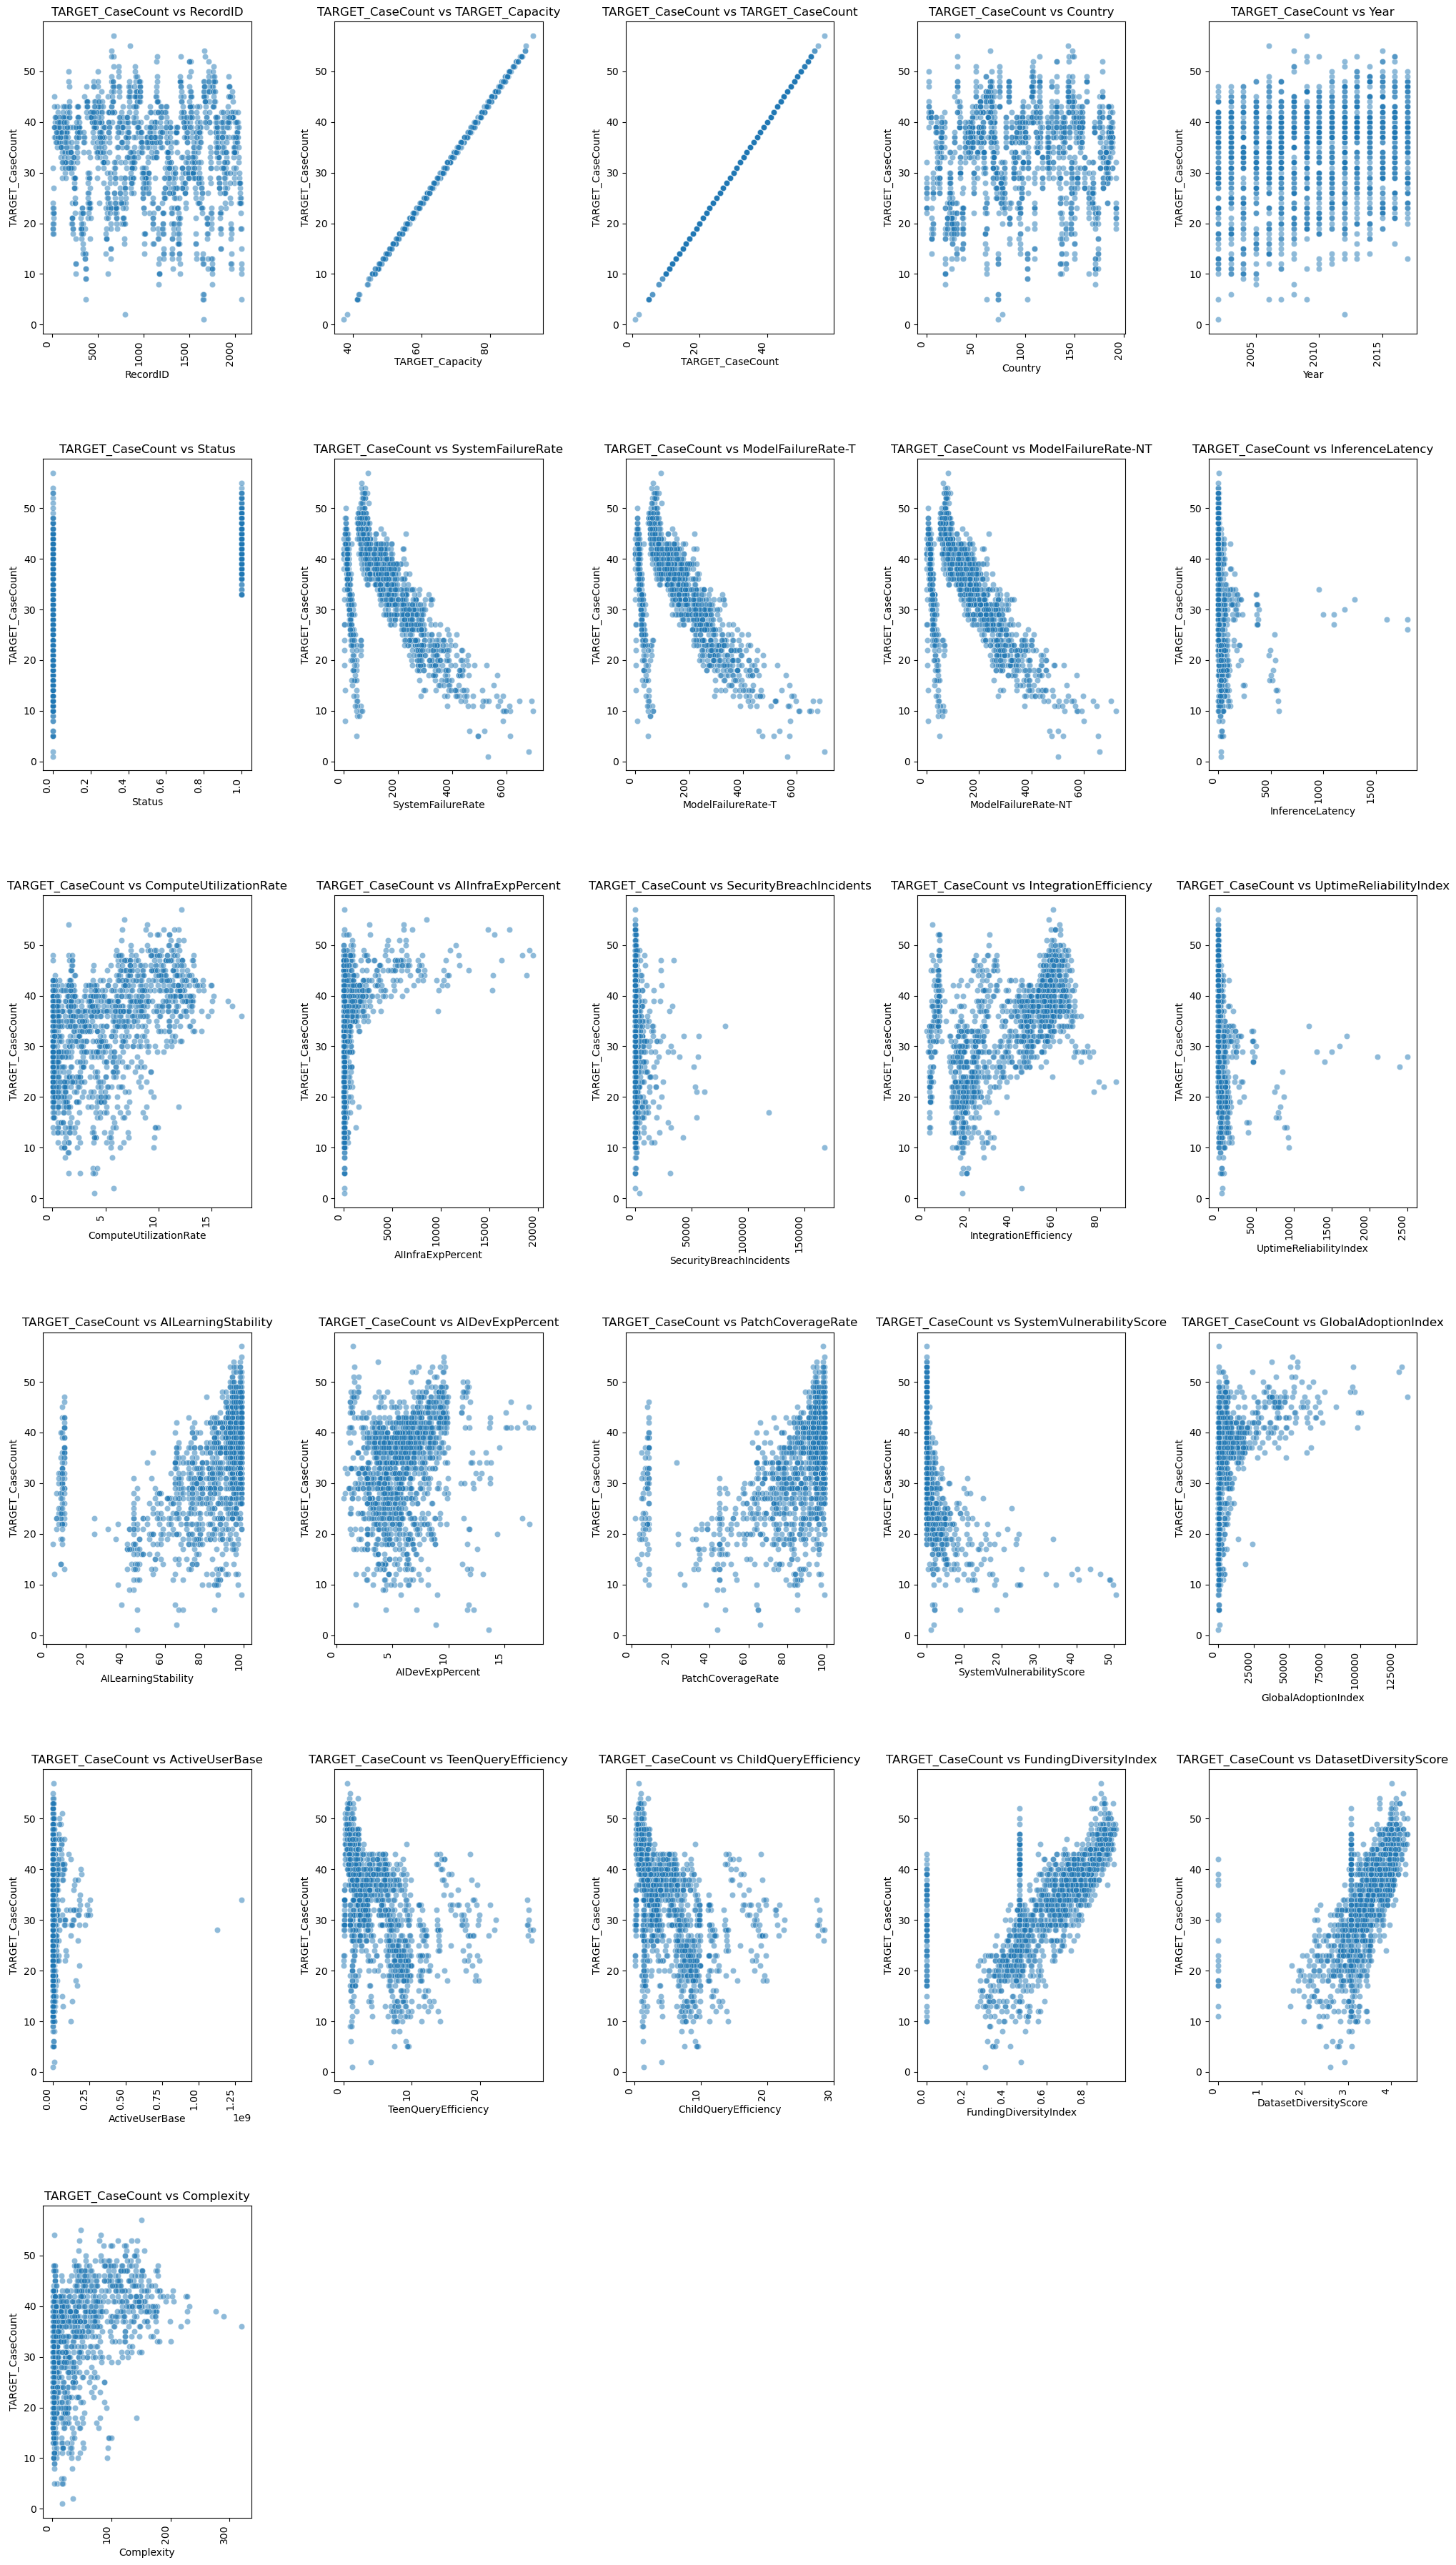

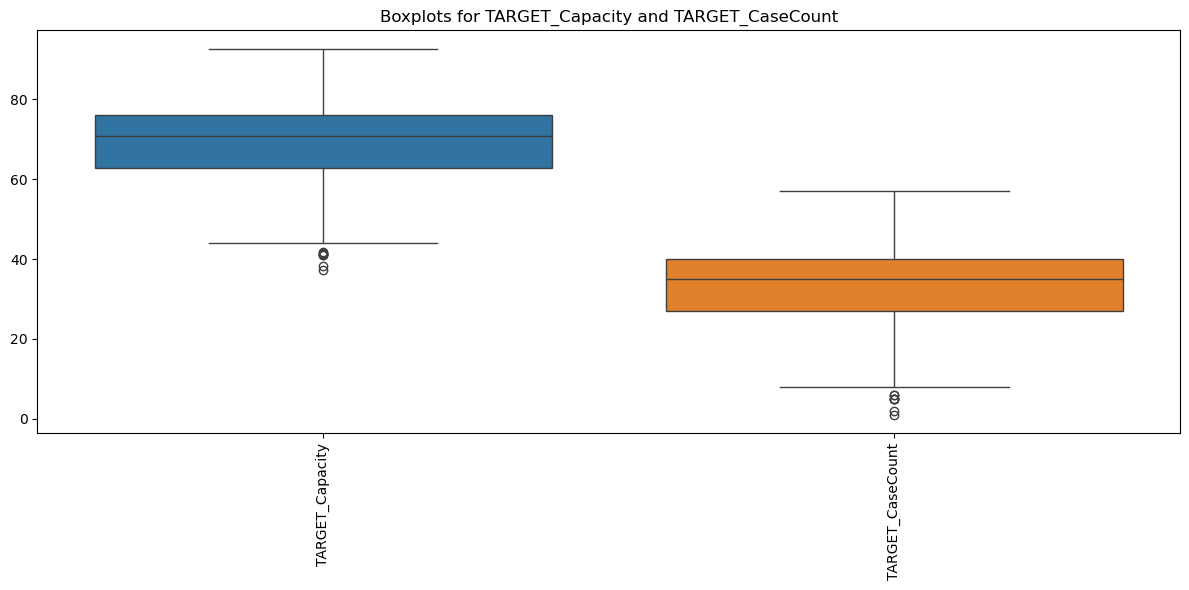

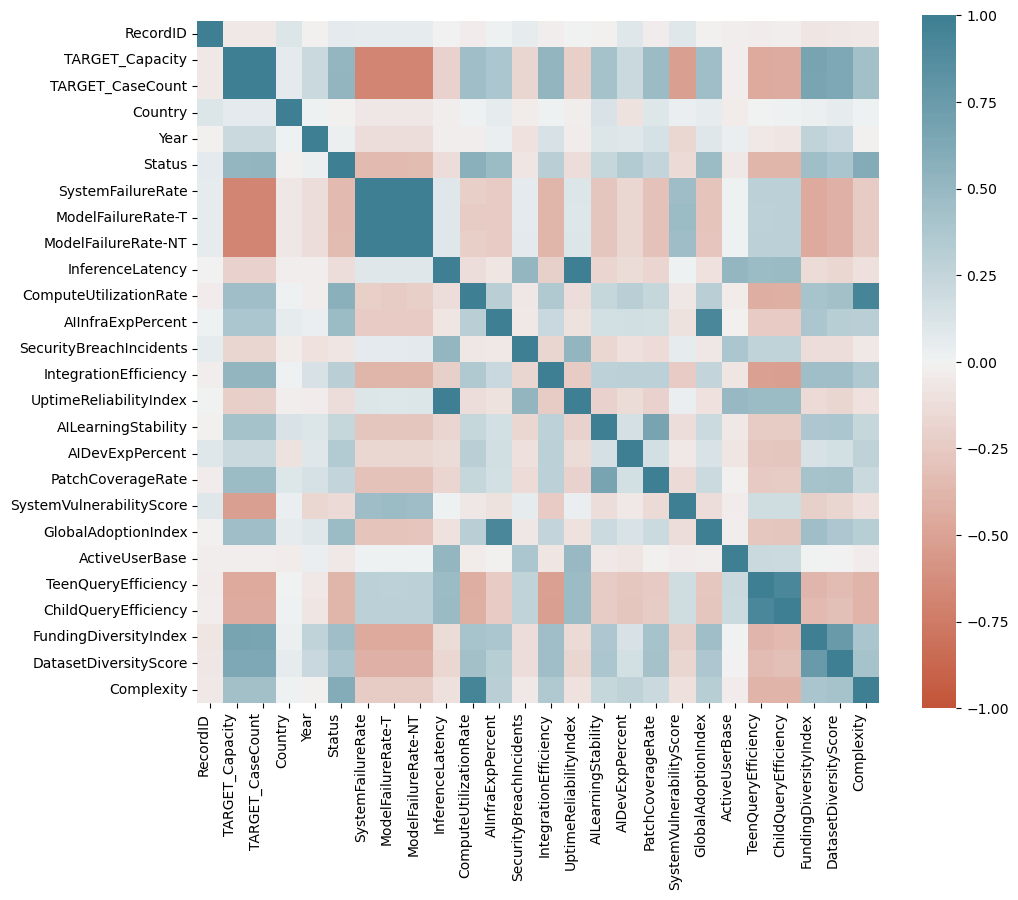

In [284]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

data = pd.read_csv('dataset/Data.csv', delimiter=',')

# Split the entire dataset into 80% training data and 20% test data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Further split: 87.5% train, 12.5% validation (i.e., 10% of total data)
train_data, val_data = train_test_split(train_data, test_size=0.125, random_state=42)

# Use the training data only for EDA
eda_data = train_data.copy()

# Automatically calculate grid size for plotting
num_cols = len(eda_data.columns)
num_rows = int(np.ceil(num_cols / 5)) 
num_cols_per_row = min(num_cols, 5)

plt.figure(figsize=(20, num_rows * 4))

# Plot histograms for each feature in the dataset
for i, col in enumerate(eda_data.columns):
    plt.subplot(num_rows, num_cols_per_row, i + 1)
    plt.hist(data[col], alpha=0.3, color='b', density=True)
    plt.title(col)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

# Plot scatter plots for TARGET_Capacity vs. the other features
plt.figure(figsize=(20, num_rows * 6))
for i, col in enumerate(eda_data.columns):
        plt.subplot(num_rows, num_cols_per_row, i + 1)
        sns.scatterplot(data=eda_data, x=col, y='TARGET_Capacity', alpha=0.5)
        plt.title(f"{'TARGET_Capacity'} vs {col}")
        plt.xlabel(col)
        plt.ylabel('TARGET_Capacity')
        plt.xticks(rotation=90, ha='right') 
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

# Plot scatter plots for TARGET_CaseCount vs. other features
plt.figure(figsize=(20, num_rows * 6))
for i, col in enumerate(eda_data.columns):
        plt.subplot(num_rows, num_cols_per_row, i + 1)
        sns.scatterplot(data=eda_data, x=col, y='TARGET_CaseCount', alpha=0.5)
        plt.title(f"{'TARGET_CaseCount'} vs {col}")
        plt.xlabel(col)
        plt.ylabel('TARGET_CaseCount')
        plt.xticks(rotation=90, ha='right') 

plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.4) 
plt.show()

# Plot Boxplots for target variables
plt.figure(figsize=(12, 6))
sns.boxplot(data=eda_data[['TARGET_Capacity', 'TARGET_CaseCount']])
plt.title('Boxplots for TARGET_Capacity and TARGET_CaseCount')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(11, 9))
corr = eda_data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);


### Data Splitting Strategy

**80% Training / 20% Testing**
- A common 80/20 split is used in Machine Learning to ensure reliable model evaluation.
- The test set (20% of the dataset) is not used during training.
- This ensures the model's performance can be assessed on unseen and unbiased data.

**Further Split of Training Data (70% Training / 10% Validation)**
- The training data is further split to create a validation set (10% of the training data).
- It will be used to fine-tune the model's hyper-parameters and to prevent overfitting before final testing is conducted.
- This leads to better generalisation as it ensures model adjustments are made based on data that is not used for training the models.

## EDA Result Analysis and Derived Conclusion

1. **Histograms**  
   - **Reason Chosen**: Histograms help determine if features need transformations such as log transformations, help analyse the distributions of all the features in the dataset and to check for skewness, spread and any outliers.
   - **Observations**:  
     - Both `TARGET_Capacity` and `TARGET_CaseCount` have wide distributions, which means that chatbot capacities and AI task execution counts are significantly different.
     - The majority of the features are positively skewed. Features with skewness > |1| (e.g., `ActiveUserBase`, `TeenQueryEfficiency` `ChildQueryEfficiency`) may require log transformations to normalise their distribution and improve model performance.
     - Features such as `PatchCoverageRate`, `AILearningStability`, and `DatasetDiversityScore` have strong negative skewness, which may suggest square or power transformations in the advanced model development.
     - Some features exhibit similar skewness (e.g., `SystemFailureRate`, `ModelFailureRate-T`, and `ModelFailureRate-NT` are positively          skewed), which could suggest correlation or multicollinearity.
     - `FundingDiversityIndex` appears to be approximately normally distributed, which may suggest that Z-score standardization is needed.
     - The `Status` attribute has only two unique values (0 and 1), confirming that it is a binary categorical variable. Although it is stored as an integer, it represents a categorical feature rather than a continuous numerical feature.”

---

2. **Scatter Plots**
    - **Reason Chosen**: Scatterplots help analyse the relationships between the target variables (`TARGET_Capacity` and `TARGET_CaseCount`) and identify trends, non-linear patterns and correlations. They can be used to determine which features are strong predictors of the target variables, which allows for accurate feature selection and model choice.
    - **Observations**:
    
      **TARGET_Capacity**
      - There is a non-linear relationship between `TARGET_Capacity` and `SystemFailureRate`, `ModelFailureRate-T`, and `ModelFailureRate-           NT`, suggesting weak predictive behaviour between them.
      - The relationship between `TARGET_Capacity` and some variables appear to be linear (e.g., `FundingDiversityIndex` and              `DatasetDiversityScore`, which may indicate they are suitable for linear regression.
      - Features such as `ActiveUserBase` and `TeenQueryEfficiency` show a positive correlation with `TARGET_Capacity`, meaning that larger values may indicate higher chatbot capacity.
      - Categorical features such as `Status` do not seem to show a clear trend, suggesting they may not have a strong contribution to the models.
      
      **TARGET_CaseCount**
      - Similar trends are observed with `TARGET_CaseCount`, where there are linear relationships with `FundingDiversityIndex` and `DatasetDiversityScore`, where there are non-linear relationships with `SystemFailureRate`, `ModelFailureRate-T` and `ModelFailureRate-NT`.
      - Categorical features such as `Status` once again does not show a clear trend with `TARGET_CaseCount`.
      - Some features, including `ActiveUserBase`, `TeenQueryEfficiency`, `ChildQueryEfficiency`, show a positive correlation, which could indicate that a higher number of AI tasks are running in parallel as these features' values increase.
      - The relationship between `TARGET_CaseCount` and `ComputeUtilisationRate` seems to be weak, which may indicate that compute utilisation does not have a strong impact on the AI execution tasks count.

---

3. **Box Plot**
    - **Reason Chosen**: Box-plots can visually display the spread and potential skewness of the target variables (`TARGET_Capacity` and `TARGET_CaseCount`). They also help highlight any extreme outliers.
    - **Observations**:
      - Both `TARGET_Capacity` and `TARGET_CaseCount` show a wide spread of values.
      - This spread could mean some chatbot systems have higher capacities or case counts than others.
      - There are quite a few outliers in both `TARGET_Capacity` and `TARGET_CaseCount`.

---

4. **Correlation Matrix**
    - **Reason Chosen**: The Correlation Matrix helps examine relationships between numerical features, which is the case for the dataset provided and identify features that are highly correlated with each other, ensuring they are either removed or combined.
    - **Observations**:
      - Both target attributes, `TARGET_Capacity` and `TARGET_CaseCount`, are highly positively correlated, indicating that chatbot capacity and the number of parallel AI tasks are strongly linked.
      - There seems to be close to no correlation between `RecordID` and `Country` and the target attributes, `TARGET_Capacity` and `TARGET_CaseCount`.
      - Some variables have a strong negative correlation with the target attributes (e.g., `SystemFailureRate`, `ModelFailureRate-T`, and `ModelFailureRate-NT`). Even though they have an Inverse relationship with the target, they could be important predictors.
      - `TARGET_Capacity` and `TARGET_CaseCount` have strong positive correlations with `FundingDiversityIndex` and `DatasetDiversityScore`, which could mean they are important predictors.
   




## Data Pre-Processing

Data preprocessing includes Normalisation or Standarisation, and PCA

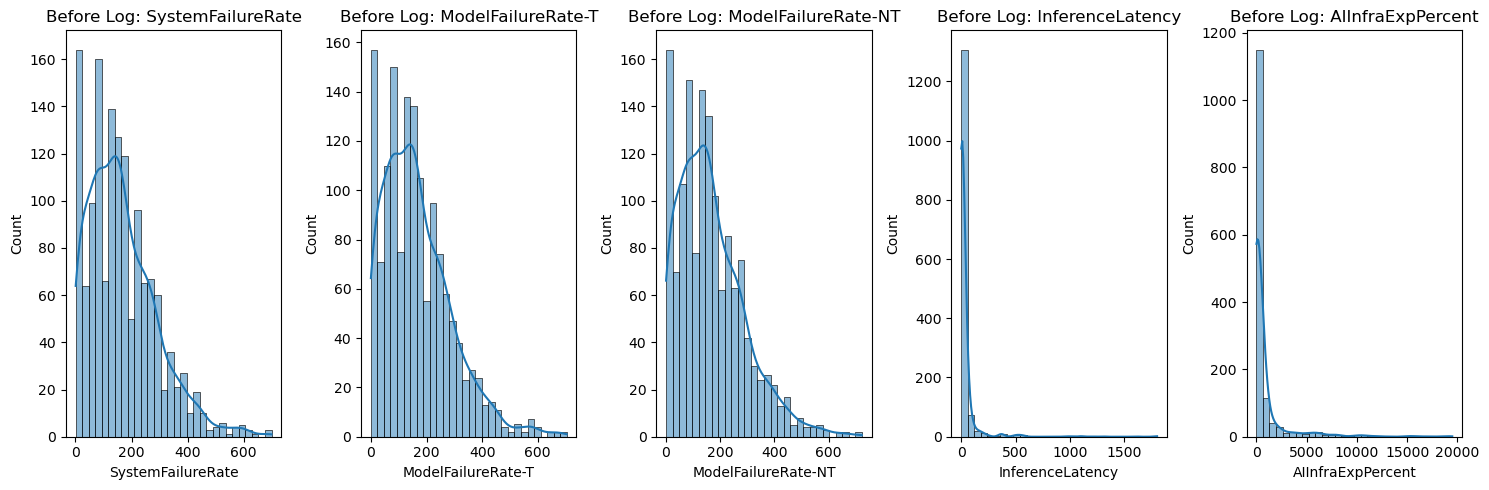

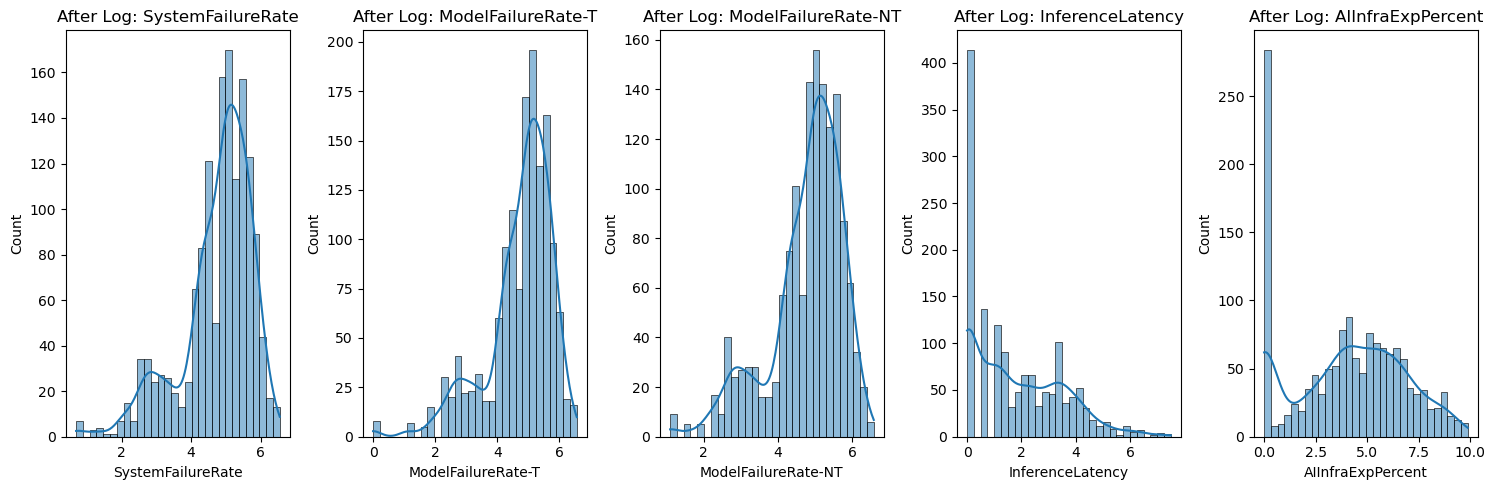

Original # of features: 22
Reduced # of PCA components: 3


In [285]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# Reload the original dataset
data = pd.read_csv('dataset/Data.csv', delimiter=',')

# Re-split to avoid chained assignment issues
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.125, random_state=42) 

# -------- LOG TRANSFORMATION --------

# Get numerical features excluding ID/status/targets
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['TARGET_Capacity', 'TARGET_CaseCount', 'RecordID', 'Status', 'Country']]

# Identify skewed features (skewness > 1)
skewness = train_data[numerical_cols].skew()
log_transform_features = skewness[skewness > 1].index.tolist()

# Show histograms of a few skewed features before transformation
log_transform_sample = log_transform_features[:5]
plt.figure(figsize=(15, 5))
for i, col in enumerate(log_transform_sample):
    plt.subplot(1, 5, i + 1)
    sns.histplot(train_data[col], kde=True, bins=30)
    plt.title(f"Before Log: {col}")
plt.tight_layout()
plt.show()

# Apply log1p transformation to skewed features
for col in log_transform_features:
    train_data[col] = np.log1p(train_data[col])
    val_data[col] = np.log1p(val_data[col])
    test_data[col] = np.log1p(test_data[col])

# Show histograms after transformation
plt.figure(figsize=(15, 5))
for i, col in enumerate(log_transform_sample):
    plt.subplot(1, 5, i + 1)
    sns.histplot(train_data[col], kde=True, bins=30)
    plt.title(f"After Log: {col}")
plt.tight_layout()
plt.show()

# -------- STANDARD SCALING (Z-score) --------

standard_features = ['FundingDiversityIndex'] # feature known to be normally distributed based on EDA
standard_scaler = StandardScaler()

# Make copies for standard scaling
train_S = train_data.copy()
val_S = val_data.copy()
test_S = test_data.copy()

# Fit on training data only then transform only the chosen standardised feature
standard_scaler.fit(train_S[standard_features])
train_S[standard_features] = standard_scaler.transform(train_S[standard_features])
val_S[standard_features] = standard_scaler.transform(val_S[standard_features])
test_S[standard_features] = standard_scaler.transform(test_S[standard_features])

# -------- MIN-MAX NORMALISATION FOR SKEWED FEATURES --------

minmax_scaler = MinMaxScaler()

# Make copies for normalisation
train_N = train_data.copy()
val_N = val_data.copy()
test_N = test_data.copy()

# Fit on training data only then transform all of the datasets
minmax_scaler.fit(train_N[log_transform_features])
train_N[log_transform_features] = minmax_scaler.transform(train_N[log_transform_features])
val_N[log_transform_features] = minmax_scaler.transform(val_N[log_transform_features])
test_N[log_transform_features] = minmax_scaler.transform(test_N[log_transform_features])

# -------- PRINCIPAL COMPONENT ANALYSIS (PCA) --------

# Exclude metadata and targets
exclude_cols = ['RecordID', 'Status', 'TARGET_Capacity', 'TARGET_CaseCount']
pca_features = [col for col in train_N.columns if col not in exclude_cols]

# Prepare data for PCA
train_pca = train_N[pca_features].copy()
val_pca = val_N[pca_features].copy()
test_pca = test_N[pca_features].copy()

# Apply PCA to retain 95% variance
pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_pca)
val_pca = pca.transform(val_pca)
test_pca = pca.transform(test_pca)

print("Original # of features:", len(pca_features))
print("Reduced # of PCA components:", pca.n_components_)

## Data Pre-Processing Justification

### Log Transformation (Handling Skewness)

- **Why applied**:  
  Most numerical features had high positive skewness, as identified in the EDA.
  
- **How applied**:  
  Log1p transformation was applied to features with skewness > 1 to:
  - Reduce outliers’ influence.
  - Normalise distributions.
  - Improve model performance and scaling.

- **What was excluded**:  
  - `RecordID` was excluded due to it being an identifier.
  - `Status` was excluded as it's a binary variable unaffected by log scaling.

- As seen in the plots, the features are now much more normally distributed, have reduced skewness and are more suitable for regression model development.
- Alternative transformations such as power transforms, square transforms and Yeo-Johnson were not applied, as log1p() was sufficient to correct high skewness and ensure better scaling compatibility.

---

### Feature Scaling

- **Why applied**:  
  To bring all features onto comparable scales and ensure fair weightage in model training.
  
- **Approach**:
  - Z-score standardisation for `FundingDiversityIndex` (normally distributed).
  - Min-max normalisation for skewed/log-transformed features.

- No plots or metrics were included for scaling, as the transformations are numerical and not visually significant after being log transformed.

---

### Principal Component Analysis (PCA)


- **Why applied**:  
  To reduce dimensionality and remove redundancy in features.
  
- **How applied**:
  - PCA was applied to the normalised datasets (`train_N`, `val_N`, `test_N`) after log transformation and scaling.
  - Retained components that explained 95% variance, which reduced dimensionality from 22 features to 3.

- **Use in modelling**:
  - These PCA datasets were **not** used directly in model development.
  - Instead, PCA was applied **after feature selection** within each advanced model pipeline for better relevance.
  - This ensures only the most important features contribute to the final components.

- The use of PCA was justified by the observed high feature correlations and the significant reduction in dimensions (from 22 to 3), making it efficient for model simplification.


## Linear Regression: Baseline and Advanced (Parameter Tuning + PCA)

- Linear regression is appropriate for predicting TARGET_Capacity due to the presence of linear patterns between certain features and the target, as observed in EDA. 
- Two models were developed: a simple baseline linear model and an advanced model using Lasso regularisation, parameter tuning with GridSearchCV, and PCA.

### Data Selection Justification for Linear Regression
- The `train_S` dataset was used for the advanced linear regression model because it applies Z-score standardisation (StandardScaler), which is suitable for normally distributed or symmetric features. 
- Linear models assume linear relationships and are sensitive to feature scales, making standardisation important for accurate coefficient interpretation and stable training.

---

### Performance Metrics Selection
Explain all the above for each task in detail, don't forget to include justification

**MAE (Mean Absolute Error)**
- Mean Absolute Error is used as it is less sensitive to outliers, providing a clear metric of average error in terms of the target variable's units.
- This is useful as the EDA revealed that the dataset has many outliers and has a large spread.

**MSE (Mean Squared Error)**
- Mean Square Error squares the error values, placing more weight on larger errors.
- It can identify if the model is making any significant mistakes when predicting.

**RMSE (Root Mean Squared Error)**
- Root Mean Squared Error is the square root of MSE and is used because it is easy to interpret as it is in the same units as the target variable, `TARGET_Capacity`.

**R² Score**
- The R² score is used to indicate how well the independent variables explain the variance in TARGET_Capacity.
- It can reveal the effectiveness of the model's predictions, where a R² score closer to 1 generally means the predictions are accurate.

---

### Explanatory Model Analysis Justification

**Predicted vs Actual Scatter Plot**
- Used to assess how close the predicted values are to the actual values.
- If datapoints lies on the diagonal line, it means that the model is making perfect predictions.
- Any datapoints that lie away from the diagonal line indicate possible error.

**Residual Plot**
- Used to show the distribution of errors as residuals across the range of predicted values.
- This can help identify homoscedasticity, which is when the variance of the residuals is constant across all non-target attributes in this case.

**Q-Q Plot**
- Used to test if the residuals follow a normal distribution, which is assumed in linear regression.
- Any deviations from the line may suggest that there are errors with the model's predictions.

**Feature Importance Plot**
- Used to show how each feature contributes to the predictions performance by randomly shuffling values.
- This can help identify which attributes the model relies on the most.

<i> Note: To reduce clutter and focus on the advanced model’s performance, visualisations for the baseline linear model were excluded from final outputs. However, baseline metrics are still presented for comparison. </i>

---

### Parameter tunning - Lasso Regularisation and GridSearchCV
- Lasso (L1) regularisation was selected as it not only penalises large coefficients to reduce overfitting but also automatically performs feature selection by shrinking some coefficients to zero.
- 	A range of alpha values (0.0001, 0.001, 0.01, 0.1, 1, 10) were tested using GridSearchCV with 5-fold cross-validation (cv=5) to identify the most effective level of regularisation for generalisation.
- max_iter was set to 100,000 to ensure training stability, especially when working with a large number of features after encoding.

---

### Feature Removal Justification

- `RecordID` was removed from all model development steps because it is a unique identifier with no predictive relationship to the target variable (`TARGET_Capacity`).
- `Country` was one-hot encoded during preprocessing in the advanced model section to convert it into a numeric format required for model input.
- One-hot encoding was only applied in the advanced models. Although it can be used in baseline models, it was used in the advanced linear model to ensure the baseline remained as simple and raw as possible, allowing for a fair and meaningful comparison.
- `Status` was not one-hot encoded as it is a binary categorical variable and most models can handle it directly without encoding.
- The Lasso model was used for feature selection as it focuses on reducing overfitting and model complexity.
- The rest of the feature selection is done through the rankings of the permutation importance plot. The top 25 most important features were retained for further processing, based on their contribution to model performance.

---

### PCA Justification
- PCA was applied after regularisation and feature selection to reduce redundancy and multicollinearity.
- The 95% variance helps simplify the model, improve computational efficiency, and prevent overfitting due to highly correlated inputs.
- PCA was only used for the advanced model to ensure fair comparisons between the baseline and advanced models.

MAE    MSE  RMSE  R² Score
Baseline Linear                3.52  21.78  4.67      0.74
Advanced Linear (Lasso + PCA)  3.11  15.88  3.99      0.81

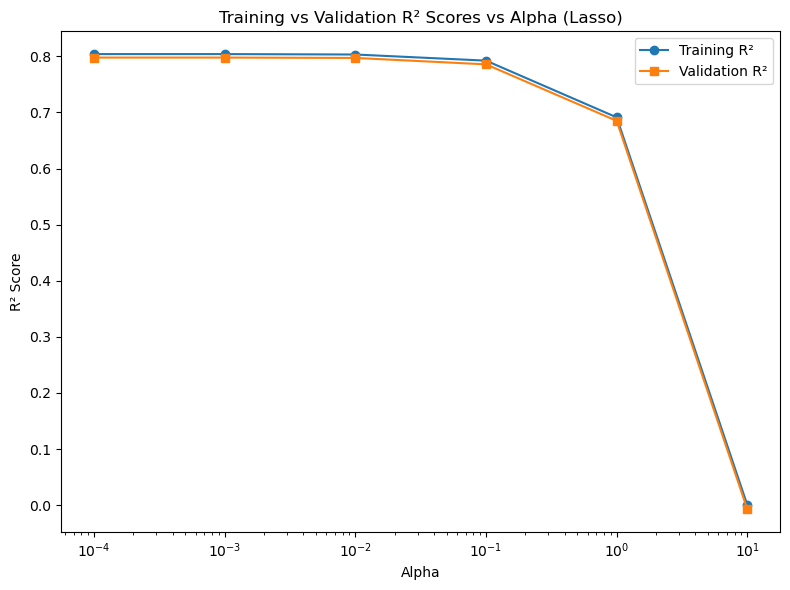

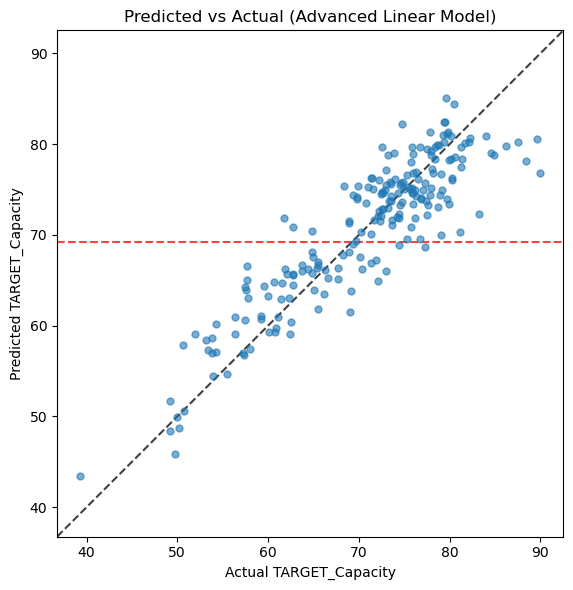

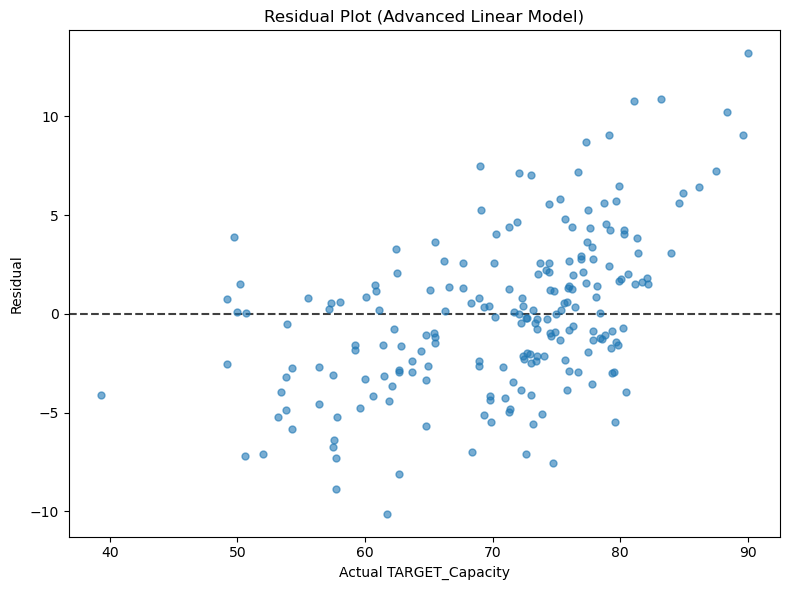

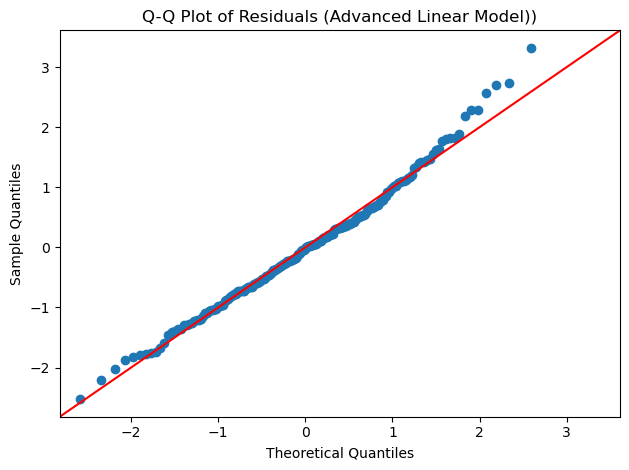

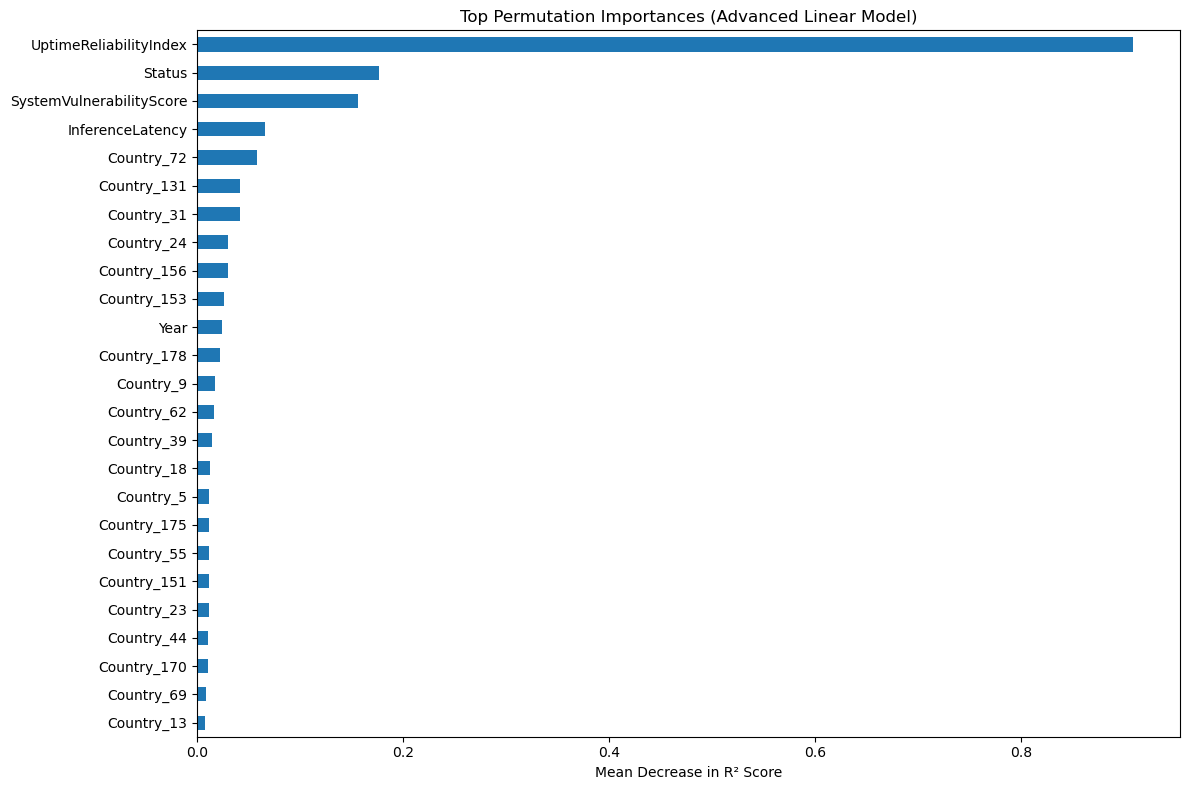

In [290]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

# -------------------- BASELINE LINEAR REGRESSION --------------------

# Prepare training and validation sets
x_train_linear = train_data.drop(columns=['TARGET_Capacity', 'TARGET_CaseCount'])
y_train_linear = train_data['TARGET_Capacity']
x_val_linear = val_data.drop(columns=['TARGET_Capacity', 'TARGET_CaseCount'])
y_val_linear = val_data['TARGET_Capacity']

# Train basic Linear Regression model
linear_regression = LinearRegression().fit(x_train_linear, y_train_linear)
y_pred_linear_baseline = linear_regression.predict(x_val_linear)

# Evaluate baseline model performance
mae_b = mean_absolute_error(y_val_linear, y_pred_linear_baseline)
mse_b = mean_squared_error(y_val_linear, y_pred_linear_baseline)
rmse_b = np.sqrt(mse_b)
r2_b = r2_score(y_val_linear, y_pred_linear_baseline)

# -------------------- ADVANCED LINEAR REGRESSION (LASSO + PCA) --------------------

# One-hot encode 'Country' and align validation columns
train_S_enc = pd.get_dummies(train_S, columns=['Country'], drop_first=True)
val_S_enc = pd.get_dummies(val_S, columns=['Country'], drop_first=True)
val_S_enc = val_S_enc.reindex(columns=train_S_enc.columns, fill_value=0)

# Prepare data
X_train_sel = train_S_enc.drop(columns=['TARGET_Capacity', 'TARGET_CaseCount', 'RecordID'])
X_val_sel = val_S_enc.drop(columns=['TARGET_Capacity', 'TARGET_CaseCount', 'RecordID'])
y_train_sel = train_S_enc['TARGET_Capacity']
y_val_sel = val_S_enc['TARGET_Capacity']

# Feature selection using permutation importance with Lasso
lasso_for_importance = Lasso(alpha=0.001, random_state=42, max_iter=100000)
lasso_for_importance.fit(X_train_sel, y_train_sel)
result = permutation_importance(lasso_for_importance, X_val_sel, y_val_sel, n_repeats=30, random_state=42, scoring='r2')
importances = pd.Series(result.importances_mean, index=X_val_sel.columns)
top_features_linear = importances.sort_values(ascending=False).head(25).index.tolist()

# Subset top features
X_train_top_linear = X_train_sel[top_features_linear]
X_val_top_linear = X_val_sel[top_features_linear]

# Standardise selected features
scaler_linear = StandardScaler()
scaler_linear.fit(X_train_top_linear)
X_train_scaled = scaler_linear.transform(X_train_top_linear)
X_val_scaled = scaler_linear.transform(X_val_top_linear)

# Hyperparameter tuning using GridSearchCV
param_grid_lasso = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'max_iter': [100000]}
lasso_linear = Lasso(random_state=42)
grid_lasso = GridSearchCV(estimator=lasso_linear, param_grid=param_grid_lasso, scoring='r2', cv=5, return_train_score=True)
grid_lasso.fit(X_train_scaled, y_train)

# Apply PCA after scaling
pca_linear = PCA(n_components=0.95)
X_train_pca_linear = pca_linear.fit_transform(X_train_scaled)
X_val_pca_linear = pca_linear.transform(X_val_scaled)

# Train advanced model
best_linear_model = grid_lasso.best_estimator_
best_linear_model.fit(X_train_pca_linear, y_train_linear)
y_pred_advanced =  best_linear_model.predict(X_val_pca_linear)

# Evaluate advanced model performance
mae_a = mean_absolute_error(y_val_sel, y_pred_advanced)
mse_a = mean_squared_error(y_val_sel, y_pred_advanced)
rmse_a = np.sqrt(mse_a)
r2_a = r2_score(y_val_sel, y_pred_advanced)

# -------------------- METRICS COMPARISON --------------------
baseline_metrics = {
    "MAE": round(mae_b, 2),
    "MSE": round(mse_b, 2),
    "RMSE": round(rmse_b, 2),
    "R² Score": round(r2_b, 2)
}

advanced_metrics = {
    "MAE": round(mae_a, 2),
    "MSE": round(mse_a, 2),
    "RMSE": round(rmse_a, 2),
    "R² Score": round(r2_a, 2)
}

comparison_df = pd.DataFrame([baseline_metrics, advanced_metrics], index=["Baseline Linear", "Advanced Linear (Lasso + PCA)"])
display(comparison_df)

# -------------------- ADVANCED MODEL PLOTS --------------------

# Error Curve Plot
cv_results = pd.DataFrame(grid_lasso.cv_results_)
cv_results['param_alpha'] = cv_results['param_alpha'].astype(float)
grouped = cv_results.groupby('param_alpha', as_index=True).mean(numeric_only=True)
alphas = grouped.index.values
mean_train_scores = grouped['mean_train_score'].values
mean_test_scores = grouped['mean_test_score'].values

plt.figure(figsize=(8, 6))
plt.plot(alphas, mean_train_scores, label='Training R²', marker='o')
plt.plot(alphas, mean_test_scores, label='Validation R²', marker='s')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('Training vs Validation R² Scores vs Alpha (Lasso)')
plt.legend()
plt.tight_layout()
plt.show()

# Predicted vs Actual Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_val_sel, y_pred_advanced, s=25, alpha=0.6, zorder=10)
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.plot(lims, [np.mean(y_train_sel)] * 2, 'r--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.xlabel("Actual TARGET_Capacity")
plt.ylabel("Predicted TARGET_Capacity")
plt.title("Predicted vs Actual (Advanced Linear Model)")
plt.tight_layout()
plt.show()

# Residual Plot
residuals = y_val_sel - y_pred_advanced
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_val_sel, residuals, s=25, alpha=0.6, zorder=10)
xlims = ax.get_xlim()
ax.plot(xlims, [0.0] * 2, 'k--', alpha=0.75, zorder=0)
ax.set_xlim(xlims)
plt.xlabel("Actual TARGET_Capacity")
plt.ylabel("Residual")
plt.title("Residual Plot (Advanced Linear Model)")
plt.tight_layout()
plt.show()

# Q-Q Plot
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Residuals (Advanced Linear Model))")
plt.tight_layout()
plt.show()

# Permutation Feature Importance Plot
plt.figure(figsize=(12, 8))
importances[top_features_linear].sort_values().plot(kind='barh')
plt.xlabel("Mean Decrease in R² Score")
plt.title("Top Permutation Importances (Advanced Linear Model)")
plt.tight_layout()
plt.show()

> <span style="font-size:1em;">✔</span> **Observations and Comparisons:**
> 
> **Note**: To improve notebook readability, the baseline linear model’s visualisations were removed from the final submission.
>
> **Feature Selection**
> - The top 25 features were chosen because:
> - Including fewer (e.g., top 10 or 15) consistently resulted in lower R² scores on validation data.
> - The top 25 features provided the best balance between model accuracy and overfitting.
> - Beyond the top 25, the incremental gain in importance dropped significantly.

> **MAE (Mean Absolute Error)**
> - The average absolute error between predicted and actual TARGET_Capacity is 3.11, which is a clear improvement from the baseline (3.52).
> - This means predictions are off by ~3 units on average, and the improvement shows better alignment with true values.

> **MSE (Mean Squared Error)**
> - The MSE dropped from 21.78 to 15.88, indicating fewer extreme prediction errors in the advanced model.
> - This reflects Lasso’s effectiveness in penalising large coefficients that cause sharp overfitting.

> **RMSE (Root Mean Squared Error)**
> - The RMSE dropped from 4.67 to 3.99, making the errors easier to interpret from the context of the target variable's, TARGET_Capacity, unit.

> **R² Score**
> - The advanced model had an R² score of 0.81, explaining 81% of the variance, compared to the baseline model's R² score of 0.74, explaining 74% of the variance.
> - This improvement shows that feature selection, regularisation (Lasso), and dimensionality reduction (PCA) improved the model’s ability to generalise to unseen data.


> **Error Curve Plot**
> - The error curve demonstrates that training and validation R² scores remain high and close together across a wide range of alpha values except at an alpha value of 10.
> - This consistency suggests low variance and no overfitting, confirming good hyperparameter selection.
> - The sudden drop at alpha=10 justifies its exclusion from the final model.


>  **Predicted vs Actual Plot**
> - Most datapoints are aligned with the red dotted line and have less spread than in the baseline.
> - There’s less underprediction and overprediction at extreme values compared to the baseline model.
> - The red mean line shows that predictions are balanced and centred well around the target mean.


> **Residual Plot**
> - The residuals are now centred around 0, which indicates no significant bias across the predictions. 
> - The spread of the residuals has reduced compared to the baseline, especially at higher target values.
> - At higher values, a few of the residuals still have larger errors, which suggests heteroscedasticity, meaning the model's uncertainty increases as the target capacity value increases.


> **Q-Q Plot**
> - Most residuals now follow the red line, indicating they are normally distributed.
> - This supports the assumption of normally distributed residuals.
> - At the tails of the red line, deviations are must more improved compared to the baseline model as they are much more aligned with the red line.

> **Note**: The features displayed in this permutation importance plot were selected using permutation importance *before* model training. The same top-ranked features were retained and used to train the final model. This plot confirms the contribution of those features after parameter tuning and PCA were applied.

> **Feature Importance**
> - UptimeReliabilityIndex, Status and SystemVulnerabilityScore are the top predictors for TARGET_Capacity.
> - Encoded Country_* variables played a significant role in prediction accuracy.
> - Most Country_* features also contributed significantly, and the inclusion of all encoded countries helped achieve the optimal performance (R² = 0.81).


## Polynomial Regression: Baseline and Advanced (Parameter Tuning + PCA)

- Polynomial regression is used to model non-linear relationships between the predictors and the target variable, `TARGET_Capacity`. 
- Applying a second-degree polynomial transformation (degree=2) allows the model to account for those curvatures in the data, especially when combined with regularisation and PCA in the advanced model development.

### Data Selection Justification for Polynomial Regression
- The `train_N` dataset was used for the polynomial regression model because it applies Min-Max scaling to skewed, log-transformed features. - Polynomial expansion significantly increases feature magnitudes, so normalisation ensures all terms remain on a comparable level and avoids numerical instability.

---

### Performance Metrics Selection
**MAE (Mean Absolute Error)**
- Mean Absolute Error is an easily intepretable metric in the same units as the target attribute, `TARGET_Capacity`.
- This is useful for understanding typical error magnitudes, especially in the presence of outliers as seen in EDA.

**MSE (Mean Squared Error)**
- MSE penalises larger errors more than MAE by squaring them, allowing the detection of whether the model is occasionally making large mistakes.

**RMSE (Root Mean Squared Error)**
- RMSE, being in the same units as the target, is useful to interpret in practical terms.
- A lower RMSE means the model’s predictions are consistently closer to the actual values.

**R² Score**
- R² represents the proportion of variance in the target variable that is explained by the model.
- A higher R² score indicates that the polynomial model effectively captures the underlying patterns in the data.

---

### Explanatory Model Analysis Justification

**Error Curve Plot**
- The training vs validation error plot is used to evaluate model generalisation.
- It helps detect overfitting (when training R² is much higher than validation R²) or underfitting (both scores are low).
- The curve shows how the model performance changes with different regularisation strengths (alpha) in Lasso Regression.
- By plotting R² scores, the optimal alpha can be chosen by balancing bias and variance.

**Predicted vs Actual Scatter Plot**
- Used to assess how close the predicted values are to the actual values.
- If datapoints lies on the diagonal line, it means that the model is making perfect predictions.
- Any datapoints that lie away from the diagonal line indicate possible error.
- In a regularised model, predictions are more aligned with the diagonal line compared to an unregularised model.

**Residual Plot**
- Used to show the distribution of errors as residuals across the range of predicted values.
- This can help identify homoscedasticity, which is when the variance of the residuals is constant across all non-target attributes in this case.

**Q-Q Plot**
- Assesses whether the residuals are normally distributed, a key assumption in regression analysis.
- Deviations at the tails can indicate skewness or the presence of outliers.

**Feature Importance Plot**
- Used to show the most important polynomial feature that contributed to the predictions performance by randomly shuffling values.
- This can help identify which attributes the model relies on the most, even with complex transformations like Polynomial Features.
- Lasso regression was used before PCA on polynomial features to calculate the importance of each feature by observing how the model’s performance drops when a feature is randomly shuffled.

<i> Note: To reduce clutter and focus on the advanced model’s performance, visualisations for the baseline polynomial model were excluded from final outputs. However, baseline metrics are still presented for comparison. </i>
  
---

### Parameter tunning - GridSearchCV with Lasso Regularisation

- Polynomial expansion introduces a large number of interaction and squared terms, increasing the risk of overfitting.
- Lasso regression was used to perform both regularisation and feature selection by shrinking some coefficients to zero.
- GridSearchCV was used to tune the alpha hyperparameter (regularisation strength) and select the best value through cross-validation.
- alpha was tuned with Lasso regression. This helped manage the high variance introduced by polynomial feature expansion. A range of values (0.0001, 0.001, 0.01, 0.1, 1, 10) were tested and the best-performing alpha was selected based on validation R².
- A 5-fold cross-validation (cv=5) was chosen to balance computation time with reliable performance estimation. It provides a good trade-off between bias and variance when assessing the model’s ability to generalise to unseen data.
- Similar to the advanced linear model, max_iter was set to 100,000 to ensure training stability, especially when working with a large number of polynomially expanded features after transformation.

---

### Feature Removal Justification

- Feature selection is based on permutation importance scores using the trained Lasso model, since it helps control multicollinearity and overfitting.
- The top 30 features that led to the highest drop in R² when permuted were selected. This ensures that only the most impactful features are retained.
- `Country` was excluded from the advanced polynomial model, through the normalisation done in the data pre-processing section, to avoid unnecessary complexity from one-hot encoding.
- Polynomial features work best with continuous numerical data, so excluding categorical features like `Country` helps prevent overfitting and keeps the model efficient.


---

### PCA Justification

- Principal Component Analysis (PCA) is applied after parameter tuning using GridSearchCV to further reduce dimensionality while keeping at least 95% of the variance.
- This step removes remaining redundancy or correlated variables.
- Reducing the number of dimensions helps improve training speed, reduce overfitting, and enhance model stability on unseen data.


MAE     MSE   RMSE  R² Score
Normal Polynomial                  3.95  166.02  12.89     -0.95
Advanced Polynomial (Lasso + PCA)  4.06   27.63   5.26      0.68

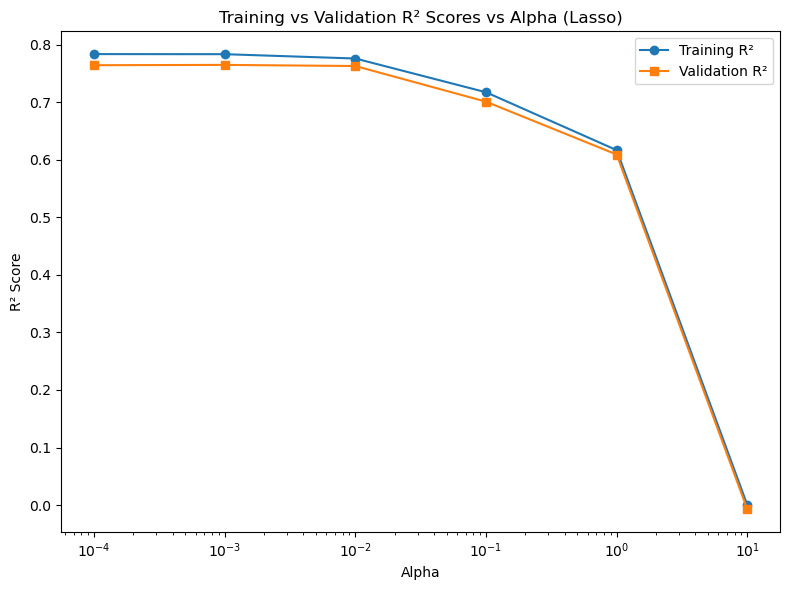

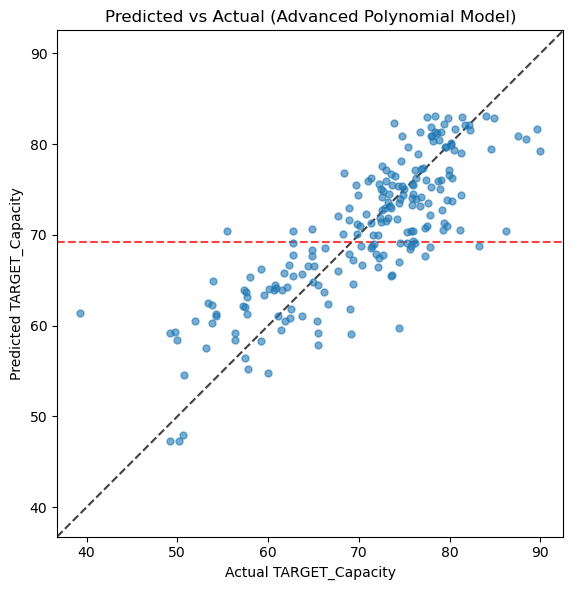

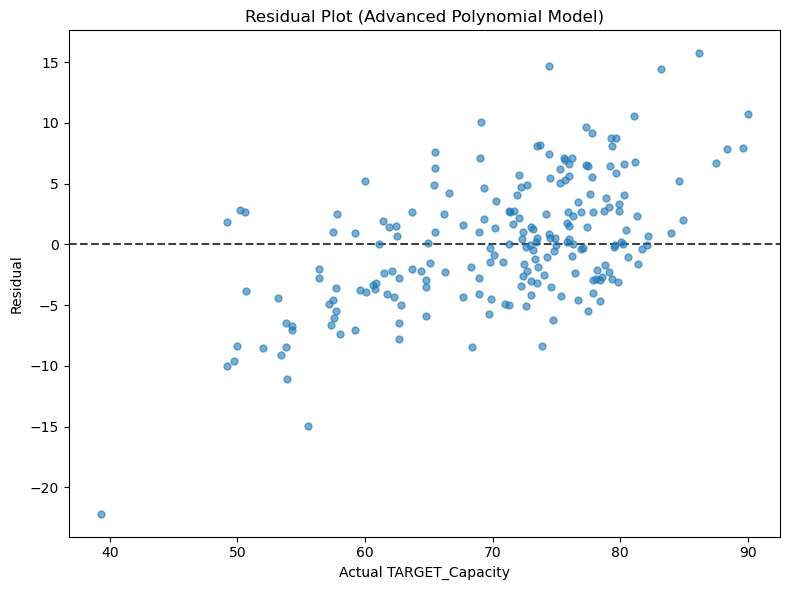

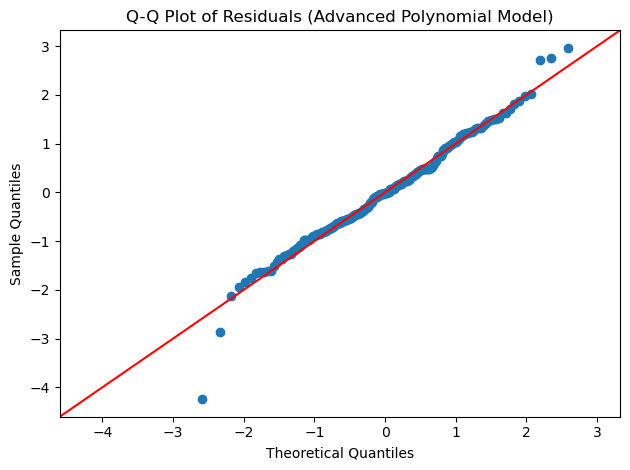

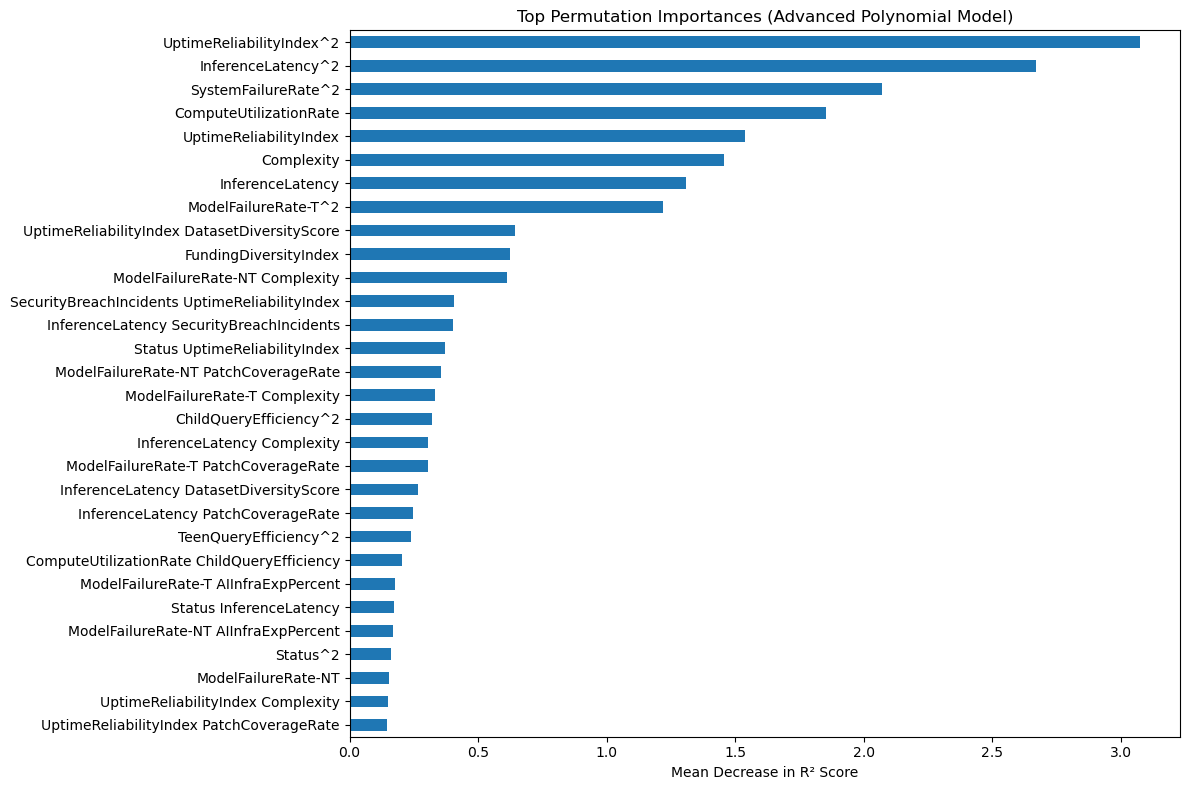

In [287]:
from sklearn.preprocessing import PolynomialFeatures

# -------------------- POLYNOMIAL REGRESSION WITHOUT PARAMETER TUNING AND PCA --------------------

# Separate input and target features
x_train_baseline = train_data.drop(columns=['TARGET_Capacity', 'TARGET_CaseCount'])
y_train_baseline = train_data['TARGET_Capacity']
x_val_baseline = val_data.drop(columns=['TARGET_Capacity', 'TARGET_CaseCount'])
y_val_baseline = val_data['TARGET_Capacity']

# Polynomial transformation (degree 2)
poly_baseline = PolynomialFeatures(degree=2, include_bias=False)
poly_baseline.fit(x_train_baseline)
x_train_poly_baseline = poly_baseline.transform(x_train_baseline)
x_val_poly_baseline = poly_baseline.transform(x_val_baseline)

# Standardise polynomial features
scaler_baseline = StandardScaler()
scaler_baseline.fit(x_train_poly_baseline)
x_train_poly_scaled_baseline = scaler_baseline.transform(x_train_poly_baseline)
x_val_poly_scaled_baseline = scaler_baseline.transform(x_val_poly_baseline)

# Train polynomial regression model
poly_model_baseline = LinearRegression()
poly_model_baseline.fit(x_train_poly_scaled_baseline, y_train_baseline)
y_pred_baseline = poly_model_baseline.predict(x_val_poly_scaled_baseline)

# Evaluate model performance
mae_poly_baseline = mean_absolute_error(y_val_baseline, y_pred_baseline)
mse_poly_baseline = mean_squared_error(y_val_baseline, y_pred_baseline)
rmse_poly_baseline = np.sqrt(mse_poly_baseline)
r2_poly_baseline = r2_score(y_val_baseline, y_pred_baseline)


# -------------------- ADVANCED POLYNOMIAL MODEL --------------------

# Use the train_N normalised dataset from preprocessing
exclude_cols = ['TARGET_Capacity', 'TARGET_CaseCount']
pca_features_poly = [col for col in train_N.columns if col not in exclude_cols]

# Standardise features
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_N[pca_features_poly])
val_scaled = scaler.transform(val_N[pca_features_poly])

# Polynomial transformation (degree 2)
poly_adv = PolynomialFeatures(degree=2, include_bias=False)
poly_adv.fit(train_scaled)
X_train_poly_adv = poly_adv.transform(train_scaled)
X_val_poly_adv = poly_adv.transform(val_scaled)

# Get feature names
feature_names = poly_adv.get_feature_names_out(pca_features_poly)

# Feature selection using permutation importance with Lasso (before PCA)
lasso_for_importance = Lasso(alpha=0.001, random_state=42, max_iter=100000)
lasso_for_importance.fit(X_train_poly_adv, train_N['TARGET_Capacity'])
result = permutation_importance(lasso_for_importance, X_val_poly_adv, val_N['TARGET_Capacity'], scoring='r2', n_repeats=30, random_state=42)
importances = pd.Series(result.importances_mean, index=feature_names)

# Select top 30 features
top_features_poly = importances.sort_values(ascending=False).head(30).index.tolist()

# Subset and re-scale top features
top_train = pd.DataFrame(X_train_poly_adv, columns=feature_names)[top_features_poly]
top_val = pd.DataFrame(X_val_poly_adv, columns=feature_names)[top_features_poly]

# Standardise selected polynomial features
scaler_poly = StandardScaler()
scaler_poly.fit(top_train)
X_train_poly_sel_scaled = scaler_poly.transform(top_train)
X_val_poly_sel_scaled = scaler_poly.transform(top_val)

# GridSearchCV for Lasso regression
param_grid_lasso = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'max_iter': [100000]}
lasso_poly = Lasso(random_state=42)
lasso_grid = GridSearchCV(estimator=lasso_poly, param_grid=param_grid_lasso, scoring='r2', cv=5, return_train_score=True)
lasso_grid.fit(X_train_poly_sel_scaled, train_N['TARGET_Capacity'])

# PCA after regularisation
pca_poly = PCA(n_components=0.95)
X_train_pca = pca_poly.fit_transform(X_train_poly_sel_scaled)
X_val_pca = pca_poly.transform(X_val_poly_sel_scaled)

# Train advanced polynomial model
final_lasso_poly = lasso_grid.best_estimator_
final_lasso_poly.fit(X_train_pca, train_N['TARGET_Capacity'])
y_pred_adv = final_lasso_poly.predict(X_val_pca)

# Evaluate advanced model performance
mae_poly_adv = mean_absolute_error(val_N['TARGET_Capacity'], y_pred_adv)
mse_poly_adv = mean_squared_error(val_N['TARGET_Capacity'], y_pred_adv)
rmse_poly_adv = np.sqrt(mse_poly_adv)
r2_poly_adv = r2_score(val_N['TARGET_Capacity'], y_pred_adv)

# -------------------- METRICS COMPARISON (POLYNOMIAL) --------------------
baseline_metrics = {
    "MAE": round(mae_poly_baseline, 2),
    "MSE": round(mse_poly_baseline, 2),
    "RMSE": round(rmse_poly_baseline, 2),
    "R² Score": round(r2_poly_baseline, 2)
}

advanced_metrics = {
    "MAE": round(mae_poly_adv, 2),
    "MSE": round(mse_poly_adv, 2),
    "RMSE": round(rmse_poly_adv, 2),
    "R² Score": round(r2_poly_adv, 2)
}

comparison_df = pd.DataFrame([baseline_metrics, advanced_metrics], index=["Normal Polynomial", "Advanced Polynomial (Lasso + PCA)"])
display(comparison_df)

# -------------------- ADVANCED MODEL PLOTS --------------------

# Error Curve Plot
cv_results = pd.DataFrame(lasso_grid.cv_results_)
# Convert param_alpha values to float
cv_results['param_alpha'] = cv_results['param_alpha'].astype(float)
grouped = cv_results.groupby('param_alpha', as_index=True).mean(numeric_only=True)
alphas = grouped.index.values
mean_train_scores = grouped['mean_train_score'].values
mean_test_scores = grouped['mean_test_score'].values

plt.figure(figsize=(8,6))
plt.plot(alphas, mean_train_scores, label='Training R²', marker='o')
plt.plot(alphas, mean_test_scores, label='Validation R²', marker='s')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('Training vs Validation R² Scores vs Alpha (Lasso)')
plt.legend()
plt.tight_layout()
plt.show()

# Predicted vs Actual Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(val_N['TARGET_Capacity'], y_pred_adv, s=25, alpha=0.6, zorder=10)
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.plot(lims, [np.mean(train_N['TARGET_Capacity'])]*2, 'r--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.xlabel("Actual TARGET_Capacity")
plt.ylabel("Predicted TARGET_Capacity")
plt.title("Predicted vs Actual (Advanced Polynomial Model)")
plt.tight_layout()
plt.show()

# Residual Plot
residuals = val_N['TARGET_Capacity'] - y_pred_adv
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(val_N['TARGET_Capacity'], residuals, s=25, alpha=0.6, zorder=10)
ax.axhline(0, color='k', linestyle='--', alpha=0.75)
plt.xlabel("Actual TARGET_Capacity")
plt.ylabel("Residual")
plt.title("Residual Plot (Advanced Polynomial Model)")
plt.tight_layout()
plt.show()

# Q-Q Plot
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Residuals (Advanced Polynomial Model)")
plt.tight_layout()
plt.show()

# Permutation Importance Plot
plt.figure(figsize=(12, 8))
importances[top_features_poly].sort_values().plot(kind='barh')
plt.xlabel("Mean Decrease in R² Score")
plt.title("Top Permutation Importances (Advanced Polynomial Model)")
plt.tight_layout()
plt.show()

> <span style="font-size:1em;">✔</span> **Observations and Comparisons:**
>
> **Note**: To improve notebook readability, the baseline polynomial model’s visualisations were removed from the final submission.
>
> **Feature Selection**
> - From this ranking, the top 30 polynomial features were selected for the advanced model, instead of 10 or 25 features.
> - This was because using 30 features achieved the highest validation R² score of 0.68, compared to lower R² scores with 10 and 25 features.
> - This shows that the previously excluded features between ranks 11-30 contained impactful variance and improved generalisation when they were included.
> - Features beyond the top 30 introduced noise, increasing complexity without improving accuracy, so they were excluded to balance complexity and performance.

> **MAE (Mean Absolute Error)**
> - Although the MAE increased slightly from 3.95 to 4.06 in the advanced model, it still remains low, suggesting that on average, predictions are still close to the actual values and only off by ~4 units.

> **MSE (Mean Squared Error)**
> - The MSE reduced significantly from 166.02 to 27.63 in the advanced model, which indicates that the advanced model made fewer large errors. Lasso regularisation likely helped 
balance the overfitting and large predictions.

> **RMSE (Root Mean Squared Error)**
> - The RMSE dropped by more than a half (12.89 to 5.26) compared to the baseline model, showing the advanced model has better alignment between actual and predicted values.

> **R² Score**
> - A negative R² score of -0.95 initially implied the model performed worse than the mean baseline.
> - This could have been due to overfitting or inaccurate predictions as there were a large number of polynomial features.
> - After applying Lasso regularisation and PCA, the score improved to 0.68 which indicates the model now explains 68% of the variation in TARGET_Capacity, highlighting improved performance.

> **Error Curve Plot**
> - The training and validation R² scores remain closely aligned across alpha values, indicating low variance and good generalisation.
> - R² decreases only at very high alpha (10), showing too much regularisation reduces model capacity.
> - The very harsh alpha value of 10 will inform GridSearchCV to not use this alpha value for the final model.
> - This justifies the selection of alpha via GridSearchCV and the use of Lasso over Ridge due to its better performance.

> **Predicted vs Actual Plot**
> - The baseline polynomial model showed predictions were not aligned with the diagonal line and had a large spread.
> - The advanced model showed predictions now closely follow the diagonal line, indicating that predictions are much more aligned with the actual target values.
> - The red dashed line (mean of y_train) is now intersected by many points near the diagonal, showing that predictions are balanced better around the mean.


> **Residual Plot**
> - The residuals in the baseline model indicated inconsistent variance and a large spread.
> - In the advanced model, the residuals are more symmetrical and centred around 0, suggesting reduced bias.
> - There is a slight increase in spread as TARGET_Capacity increases, suggesting some variance still exists at higher values but much less than before.
> - There are fewer extreme residuals, suggesting stronger generalisation.


> **Q-Q Plot**
> - The baseline polynomial model had strong deviations from the centre of distribution.
> - Now, in the advanced model the Q-Q plot indicates that residuals are closer to the red diagonal line, especially in the centre of the distribution.
> - There’s slight deviation at the tails, suggesting some minor skewness and presence of a few mild outliers, but this is expected since outliers were not removed from the dataset.

> **Note**: The features displayed in this permutation importance plot were selected using permutation importance *before* model training. The same top-ranked features were retained and used to train the final model. This plot confirms the contribution of those features after parameter tuning and PCA were applied.

> **Permutation Feature Importance Plot**
> - The most important features are UptimeReliabilityIndex², InferenceLatency² and SystemFailureRate².
> - These variables logically relate to chatbot reliability, efficiency, and capacity.
> - The Lasso model’s ability to eliminate unimportant features supported this selection, with regularisation applied prior to PCA, ensuring more stable importance estimates.

## Poisson Regression: Baseline and Advanced (Regularisation + PCA)

- Poisson Regression is used for predicting TARGET_CaseCount, which is a count-based target variable. 
- This model is suitable as it assumes non-negative integers and models the log of the expected counts, making it ideal for modelling frequency-based tasks.

### Data Selection Justification for Poisson Regression
- The `train_N` dataset was used for the advanced Poisson regression model because it contains normalised values of skewed and log-transformed features using Min-Max scaling. 
- Since Poisson regression assumes non-negative count data and is sensitive to feature magnitude, applying normalisation helps stabilise the optimisation process.

---

### Performance Metrics Selection

**MAE (Mean Absolute Error)**  
- Provides a straightforward interpretation of average prediction error in the same units as `TARGET_CaseCount`.
- It directly shows the average error in predicting the number of AI task executions.
- This is especially useful for count data with potentially large deviations.

**MSE (Mean Squared Error)**  
- Highlights large deviations more than MAE due to squaring the errors.
- Helps detect instances where the model may significantly over/underpredict task execution counts.

**RMSE (Root Mean Squared Error)**  
- Makes MSE easier to interpret by keeping it as the same unit as the target variable (`TARGET_CaseCount`).
- It is useful for comparing different models on the same dataset, which is the case here between the baseline and advanced Poisson models.

**R² Score**
- R² was used here as a consistent evaluation metric across all models for comparison purposes.
- Even though it is less common to use for count data, it provides a general idea of how well the model explains variance in the target.
 
---

### Explanatory Model Analysis Justification

**Predicted vs Actual Scatter Plot**  
- Visualises how close the model's predictions are to actual `TARGET_CaseCount` values.
- Data points lying close to the diagonal line suggest strong predictive performance, while large deviations can indicate model limitations.

**Residual Plot**  
- Displays the difference between actual and predicted values.
- Used to identify patterns such as heteroskedasticity (non-constant variance), which is common in Poisson models.
- Useful to spot areas where the model systematically under- or over-predicts.

**Q-Q Plot**
- Assesses whether the residuals are normally distributed, a key assumption in regression analysis.
- Deviations at the tails can indicate skewness or the presence of outliers.

**Feature Importance Plot (Permutation)**  
- Used to measure the contribution of each feature by assessing how much model performance degrades when a feature's values are shuffled.
- Helps determine which features most influence the `TARGET_CaseCount` prediction.

<i> Note: To reduce clutter and focus on the advanced model’s performance, visualisations for the baseline poisson model were excluded from final outputs. However, baseline metrics are still presented for comparison. </i>

---

### Feature Selection Justification**
- `RecordID`, `Status` and `Country` were excluded from the advanced Poisson model.
    - `RecordID`: A unique identifier with no predictive value. Including it can lead to overfitting and data leakage.
	- `Status`: A binary categorical variable (0/1) is not suitable for scaling.
	- `Country`: Multi-class categorical variable that is not one-hot encoded for Poisson models in this case. This is due to the added complexity it could bring with the additional Country features. Poisson Regression is also already sensitive to multicollinearity, which one-hot encoding would increase.
- PoissonRegressor was used as the estimator for permutation importance to ensure that feature relevance was evaluated using the same model assumptions (count-based target and log-linear relationship) intended for final prediction.
- Feature importance was computed using permutation importance before PCA, and the top 15 features were selected based on their contribution to validation performance.
- This ensures that PCA is only applied to important features, improving the effectiveness of dimensionality reduction.

---

### Regularisation and PCA Justification**
- Regularisation was applied through the in-built L2 Regularisation of PoissonRegressor before PCA to manage high dimensionality and prevent overfitting from correlated features.
- alpha was tuned using GridSearchCV to control regularisation strength in Poisson regression. A range of values (0.0001, 0.001, 0.01, 0.1, 1, 10) were tested to prevent over-penalising important coefficients while improving generalisability. The best alpha was selected based on validation R² performance.
- max_iter was set to 10,000 as Poisson regression typically converges faster and does not require as many iterations as more complex models.
- PCA was then applied to reduce dimensionality while preserving 95% of the variance from the scaled and regularised feature set.
- This sequence avoids redundancy, stabilises model training, and improves generalisation on validation data.

MAE    MSE  RMSE  R² Score
Baseline Poisson                         3.69  22.91  4.79      0.73
Advanced Poisson (Regularisation + PCA)  3.54  22.40  4.73      0.74

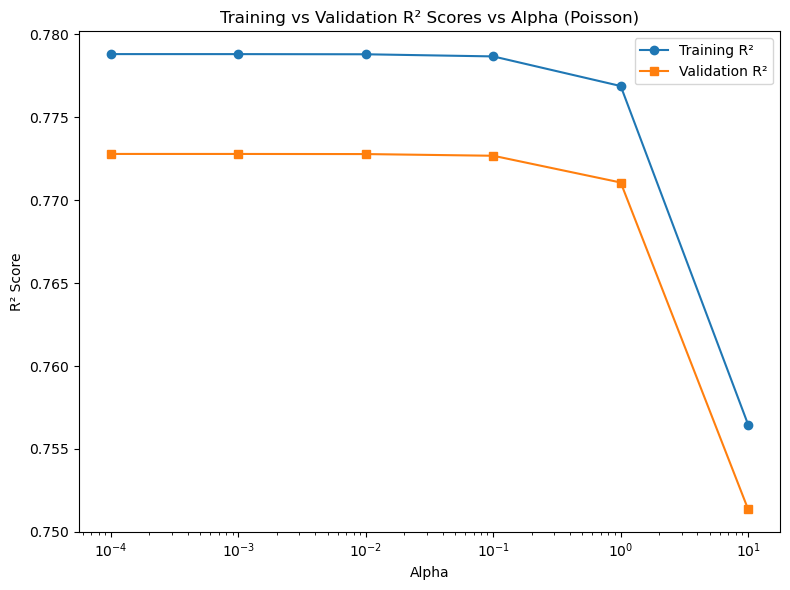

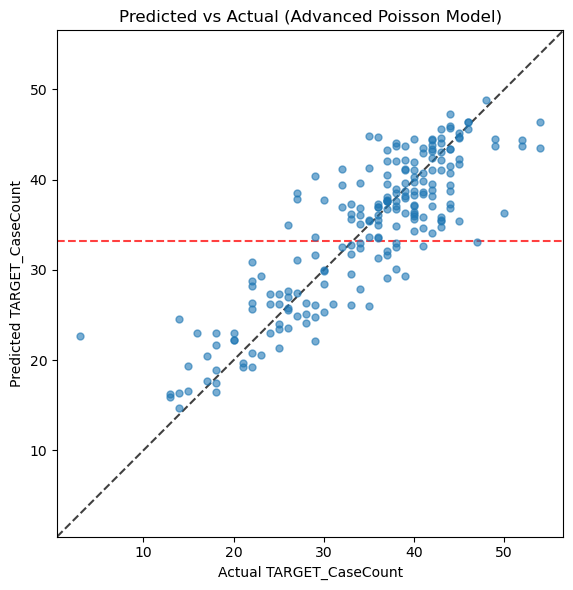

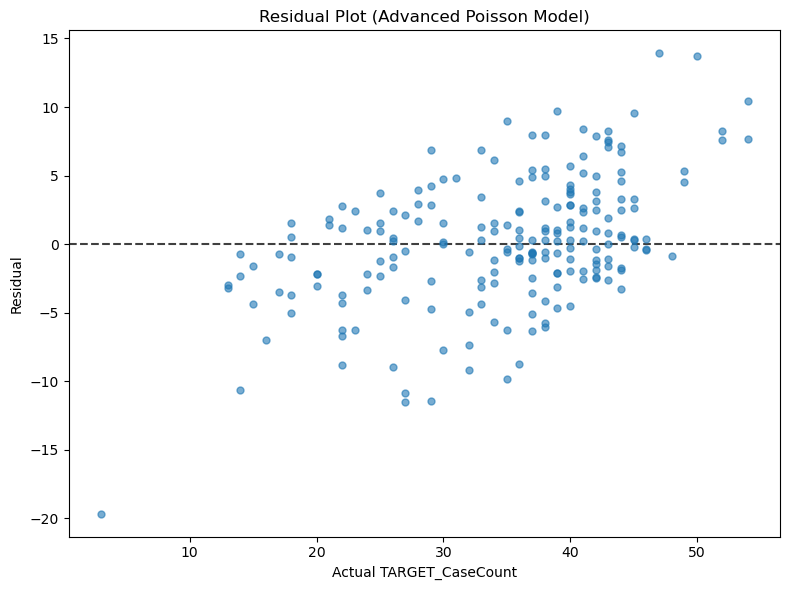

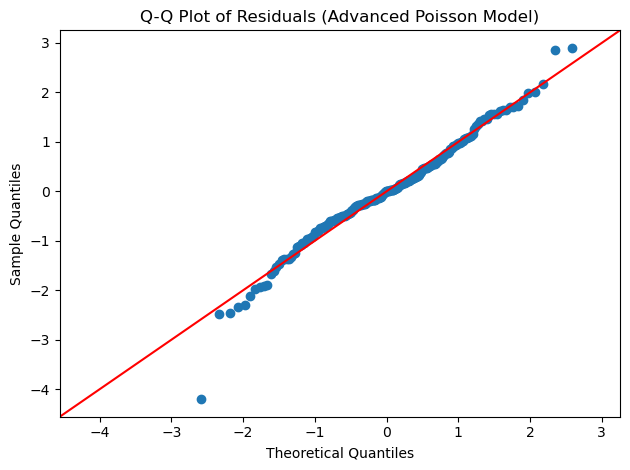

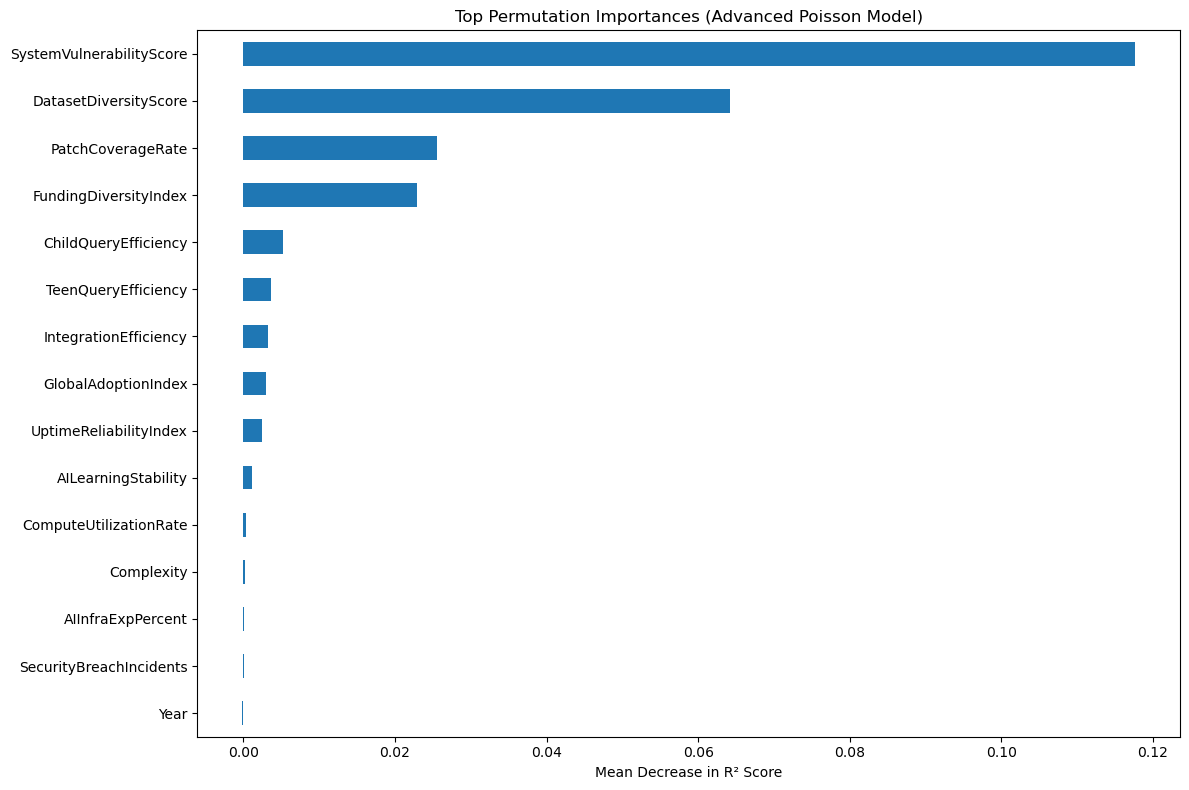

In [288]:
from sklearn.linear_model import PoissonRegressor

# -------------------- BASELINE POISSON REGRESSION --------------------

# Prepare inputs and targets
x_train_poisson = train_data.drop(columns=['TARGET_Capacity', 'TARGET_CaseCount'])
y_train_poisson = train_data['TARGET_CaseCount']
x_val_poisson = val_data.drop(columns=['TARGET_Capacity', 'TARGET_CaseCount'])
y_val_poisson = val_data['TARGET_CaseCount']

# Standardise features
scaler = StandardScaler()
scaler.fit(x_train_poisson)
x_train_scaled_poisson = scaler.transform(x_train_poisson)
x_val_scaled_poisson = scaler.transform(x_val_poisson)

# Train baseline Poisson regression model
poisson_baseline = PoissonRegressor()
poisson_baseline.fit(x_train_scaled_poisson, y_train_poisson)
y_pred_baseline = poisson_baseline.predict(x_val_scaled_poisson)

# Evaluate baseline Poisson model performance
mae_b = mean_absolute_error(y_val_poisson, y_pred_baseline)
mse_b = mean_squared_error(y_val_poisson, y_pred_baseline)
rmse_b = np.sqrt(mse_b)
r2_b = r2_score(y_val_poisson, y_pred_baseline)

# -------------------- ADVANCED POISSON REGRESSION --------------------

# Drop categorical columns from the normalised data
x_train_N = train_N.drop(columns=['TARGET_Capacity', 'TARGET_CaseCount', 'Status', 'Country', 'RecordID'])
x_val_N = val_N.drop(columns=['TARGET_Capacity', 'TARGET_CaseCount', 'Status', 'Country', 'RecordID'])
y_train_N = train_N['TARGET_CaseCount']
y_val_N = val_N['TARGET_CaseCount']

# Feature selection using permutation importance
poisson_importance = PoissonRegressor(alpha=1.0, max_iter=10000)
poisson_importance.fit(x_train_N, y_train_N)
result = permutation_importance(poisson_importance, x_val_N, y_val_N, n_repeats=30, random_state=42, scoring='r2')
importances = pd.Series(result.importances_mean, index=x_val_N.columns)
top_features_poisson = importances.sort_values(ascending=False).head(15).index.tolist()

# Subset top features
X_train_top = x_train_N[top_features_poisson]
X_val_top = x_val_N[top_features_poisson]

# Standardise top features
scaler_poisson = StandardScaler()
X_train_scaled_final = scaler_poisson.fit_transform(X_train_top)
X_val_scaled_final = scaler_poisson.transform(X_val_top)

# GridSearchCV for Poisson model
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'max_iter': [10000]}
poisson = PoissonRegressor()
grid = GridSearchCV(estimator=poisson, param_grid=param_grid, cv=5, scoring='r2', return_train_score=True)
grid.fit(X_train_scaled_final, y_train_N)

# Implement PCA on the top features
pca_poisson = PCA(n_components=0.95)
X_train_pca = pca_poisson.fit_transform(X_train_scaled_final)
X_val_pca = pca_poisson.transform(X_val_scaled_final)

# Train the advanced Poisson model
best_poisson_model = grid.best_estimator_
best_poisson_model.fit(X_train_pca, y_train_N)
y_pred_poisson_adv = best_poisson_model.predict(X_val_pca)

# Evaluate the advanced Poisson model performance
mae_a = mean_absolute_error(y_val_N, y_pred_poisson_adv)
mse_a = mean_squared_error(y_val_N, y_pred_poisson_adv)
rmse_a = np.sqrt(mse_a)
r2_a = r2_score(y_val_N, y_pred_poisson_adv)


# -------------------- METRICS COMPARISON --------------------
baseline_metrics = {
    "MAE": round(mae_b, 2),
    "MSE": round(mse_b, 2),
    "RMSE": round(rmse_b, 2),
    "R² Score": round(r2_b, 2)
}

advanced_metrics = {
    "MAE": round(mae_a, 2),
    "MSE": round(mse_a, 2),
    "RMSE": round(rmse_a, 2),
    "R² Score": round(r2_a, 2)
}

comparison_df = pd.DataFrame([baseline_metrics, advanced_metrics], index=["Baseline Poisson", "Advanced Poisson (Regularisation + PCA)"])
display(comparison_df)

# -------------------- ADVANCED MODEL PLOTS --------------------

# Error Curve Plot
cv_results = pd.DataFrame(grid.cv_results_)
cv_results['param_alpha'] = cv_results['param_alpha'].astype(float)
grouped = cv_results.groupby('param_alpha', as_index=True).mean(numeric_only=True)
alphas = grouped.index.values
mean_train_scores = grouped['mean_train_score'].values
mean_test_scores = grouped['mean_test_score'].values

plt.figure(figsize=(8, 6))
plt.plot(alphas, mean_train_scores, label='Training R²', marker='o')
plt.plot(alphas, mean_test_scores, label='Validation R²', marker='s')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('Training vs Validation R² Scores vs Alpha (Poisson)')
plt.legend()
plt.tight_layout()
plt.show()

# Predicted vs Actual Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_val_poisson, y_pred_poisson_adv, s=25, alpha=0.6, zorder=10)
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.plot(lims, [np.mean(y_train)] * 2, 'r--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.xlabel("Actual TARGET_CaseCount")
plt.ylabel("Predicted TARGET_CaseCount")
plt.title("Predicted vs Actual (Advanced Poisson Model)")
plt.tight_layout()
plt.show()

# Residual Plot
residuals = y_val_poisson - y_pred_poisson_adv
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_val, residuals, s=25, alpha=0.6, zorder=10)
xlims = ax.get_xlim()
ax.plot(xlims, [0.0] * 2, 'k--', alpha=0.75, zorder=0)
ax.set_xlim(xlims)
plt.xlabel("Actual TARGET_CaseCount")
plt.ylabel("Residual")
plt.title("Residual Plot (Advanced Poisson Model)")
plt.tight_layout()
plt.show()

# Q-Q Plot
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Residuals (Advanced Poisson Model)")
plt.tight_layout()
plt.show()

# Permutation Feature Importance Plot
plt.figure(figsize=(12, 8))
importances[top_features_poisson].sort_values().plot(kind='barh')
plt.xlabel("Mean Decrease in R² Score")
plt.title("Top Permutation Importances (Advanced Poisson Model)")
plt.tight_layout()
plt.show()

> <span style="font-size:1em;">✔</span> **Observations and Comparisons:**
>
> **Note**: To improve notebook readability, the baseline Poisson model’s visualisations were removed from the final submission.

> **Feature Selection**
> - The top 15 features were selected based on permutation importance scores computed before applying PCA or training the final model.
> - This number was chosen after testing various thresholds, and 15 features provided the highest validation R² without introducing excess noise.
> - Features beyond the top 15 showed a slightly lower R² score and added unnecessary complexity, which would have increased the risk of overfitting and reduced interpretability.

> **MAE (Mean Absolute Error)**
> - The advanced model reduced the average absolute prediction error by ~0.15 units, down to 3.54 from 3.69.
> - This indicates improved prediction accuracy for the count of AI task executions.

> **MSE (Mean Squared Error)**
> - A moderate improvement from 22.91 to 22.40 suggests the advanced model made fewer large-magnitude errors.

> **RMSE (Root Mean Squared Error)**
> - RMSE is slightly lower from 4.79 to 4.73, suggesting a better overall fit despite the count-based nature of the target.

> **R² Score**
> - Although Poisson regression is not always evaluated with R², its used here for comparability.
> - Slightly increase from 0.73 to 0.74, showing that the advanced model explains the a slight increase in variance in TARGET_CaseCount.

> **Error Curve Plot**
> - The R² scores for both training and validation sets were at their highest for lower alpha values (0.0001 – 0.1).
> - Performance dropped significantly at alpha = 10, suggesting too much regularisation at that level.
> - This shows that regularisation strength must be carefully balanced, especially when paired with PCA. 

>  **Predicted vs Actual Scatter Plot**
> - Most predictions fall close to the diagonal line, indicating a good alignment between predicted and actual values.
> - Compared to the baseline model, there is less extreme over/underestimation, especially at higher count values.
> - Predictions remain balanced around the red horizontal line (training mean), indicating no significant skewness in predictions.

> **Residual Plot**
> - Residuals are more tightly centred around 0 in the advanced model than in the baseline.
> - The spread of residuals at higher actual values has noticeably reduced, suggesting improved consistency.
> - There are now fewer negative residuals appearing at higher actual values, indicating the model underpredicts less in critical areas.

> **Q-Q Plot**
> - Residuals generally follow the red reference line in the Q-Q plot, especially near the centre of the distribution.
> - Deviations at the tails suggest non-normal residuals, which is expected in Poisson models due to the count-based nature of the target.
> - These small deviations suggest some outliers or mild skewness, but this is expected since outliers were not removed.

> **Note**: The features displayed in this permutation importance plot were selected using permutation importance *before* model training. The same top-ranked features were retained and used to train the final model. This plot confirms the contribution of those features after regularisation and PCA were applied.

> **Permutation Feature Importance**
> - The most important features were `SystemVulnerabilityScore`, `DatasetDiversityScore`, and `PatchCoverageRate`.
> - These features showed the highest mean decrease in R² when permuted, confirming their importance to model predictions.
> - Features such as `AIDevExpPercent`, `SecurityBreachIncidents`, and `Year` were ranked lower in importance but still included among the top 15, indicating that while they contribute less, they were still retained during feature selection.


In [289]:
# -------------------- TEST SET EVALUATION FOR ALL MODELS --------------------

# -------- LINEAR BASELINE --------
# Prepare test features and target
X_test_linear_base = test_data.drop(columns=['TARGET_Capacity', 'TARGET_CaseCount'])
y_test_linear_base = test_data['TARGET_Capacity']

# Predict using baseline linear model
y_pred_linear_base = linear_regression.predict(X_test_linear_base)


# -------- LINEAR ADVANCED (Lasso + PCA) --------
# Encode categorical feature "Country" to match training
test_S_enc = pd.get_dummies(test_S, columns=['Country'], drop_first=True)
test_S_enc = test_S_enc.reindex(columns=train_S_enc.columns, fill_value=0)

# Extract top features and target
X_test_linear_adv = test_S_enc.drop(columns=['TARGET_Capacity', 'TARGET_CaseCount', 'RecordID'])[top_features_linear]
y_test_linear_adv = test_S_enc['TARGET_Capacity']

# Apply scaling and PCA transformations
X_test_scaled_linear = scaler_linear.transform(X_test_linear_adv)
X_test_pca_linear = pca_linear.transform(X_test_scaled_linear)

# Predict using advanced linear model
y_pred_linear_adv = best_linear_model.predict(X_test_pca_linear)


# -------- POLYNOMIAL BASELINE (degree=2) --------
# Use raw test data (no preprocessing)
X_test_poly_raw = test_data.drop(columns=['TARGET_Capacity', 'TARGET_CaseCount'])

# Apply the same polynomial transformation and scaling from training
X_test_poly_base = poly_baseline.transform(X_test_poly_raw)
X_test_poly_scaled_base = scaler_baseline.transform(X_test_poly_base)

# Extract target and predict
y_test_poly_base = test_data['TARGET_Capacity']
y_pred_poly_base = poly_model_baseline.predict(X_test_poly_scaled_base)


# -------- POLYNOMIAL ADVANCED (degree=2 + Lasso + PCA) --------
# Use the normalised and standardised test data
X_test_poly_input = test_N[pca_features_poly]
X_test_poly_scaled = scaler.transform(X_test_poly_input)

# Apply polynomial transformation
X_test_poly_transformed = poly_adv.transform(X_test_poly_scaled)

# Select the top features identified during training
X_test_poly_df = pd.DataFrame(X_test_poly_transformed, columns=feature_names)[top_features_poly]

# Standardise the top features and apply PCA
X_test_poly_sel_scaled = scaler_poly.transform(X_test_poly_df)
X_test_pca_poly = pca_poly.transform(X_test_poly_sel_scaled)

# Extract target and predict
y_test_poly_adv = test_N['TARGET_Capacity']
y_pred_poly_adv = final_lasso_poly.predict(X_test_pca_poly)


# -------- POISSON BASELINE --------
# Prepare the raw features and target for baseline Poisson model
X_test_poisson_base = test_data.drop(columns=['TARGET_Capacity', 'TARGET_CaseCount'])
y_test_poisson_base = test_data['TARGET_CaseCount']

# Apply scaler used during training
X_test_scaled_poisson_base = scaler.transform(X_test_poisson_base)

# Predict using baseline Poisson model
y_pred_poisson_base = poisson_baseline.predict(X_test_scaled_poisson_base)


# -------- POISSON ADVANCED --------
# Prepare the test features using top selected features
X_test_poisson = test_N.drop(columns=['TARGET_Capacity', 'TARGET_CaseCount', 'Status', 'Country', 'RecordID'])[top_features_poisson]

# Apply scaling and PCA
X_test_scaled_poisson = scaler_poisson.transform(X_test_poisson)
X_test_pca_poisson = pca_poisson.transform(X_test_scaled_poisson)

# Extract target and predict
y_test_poisson_adv = test_N['TARGET_CaseCount']
y_pred_poisson_adv = best_poisson_model.predict(X_test_pca_poisson)

# EVALUATION FUNCTION
def eval_metrics(y_true, y_pred):
    return [
        round(mean_absolute_error(y_true, y_pred), 2),
        round(mean_squared_error(y_true, y_pred), 2),
        round(np.sqrt(mean_squared_error(y_true, y_pred)), 2),
        round(r2_score(y_true, y_pred), 2)
    ]

results = {
    "Model": [
        "Baseline Linear",
        "Advanced Linear (Lasso + PCA)",
        "Baseline Polynomial",
        "Advanced Polynomial (Lasso + PCA)",
        "Baseline Poisson",
        "Advanced Poisson (Regularised + PCA)"
    ],
    "MAE": [],
    "MSE": [],
    "RMSE": [],
    "R² Score": []
}

results["MAE"].extend([
    eval_metrics(y_test_linear_base, y_pred_linear_base)[0],
    eval_metrics(y_test_linear_adv, y_pred_linear_adv)[0],
    eval_metrics(y_test_poly_base, y_pred_poly_base)[0],
    eval_metrics(y_test_poly_adv, y_pred_poly_adv)[0],
    eval_metrics(y_test_poisson_base, y_pred_poisson_base)[0],
    eval_metrics(y_test_poisson_adv, y_pred_poisson_adv)[0]
])
results["MSE"].extend([
    eval_metrics(y_test_linear_base, y_pred_linear_base)[1],
    eval_metrics(y_test_linear_adv, y_pred_linear_adv)[1],
    eval_metrics(y_test_poly_base, y_pred_poly_base)[1],
    eval_metrics(y_test_poly_adv, y_pred_poly_adv)[1],
    eval_metrics(y_test_poisson_base, y_pred_poisson_base)[1],
    eval_metrics(y_test_poisson_adv, y_pred_poisson_adv)[1]
])
results["RMSE"].extend([
    eval_metrics(y_test_linear_base, y_pred_linear_base)[2],
    eval_metrics(y_test_linear_adv, y_pred_linear_adv)[2],
    eval_metrics(y_test_poly_base, y_pred_poly_base)[2],
    eval_metrics(y_test_poly_adv, y_pred_poly_adv)[2],
    eval_metrics(y_test_poisson_base, y_pred_poisson_base)[2],
    eval_metrics(y_test_poisson_adv, y_pred_poisson_adv)[2]
])
results["R² Score"].extend([
    eval_metrics(y_test_linear_base, y_pred_linear_base)[3],
    eval_metrics(y_test_linear_adv, y_pred_linear_adv)[3],
    eval_metrics(y_test_poly_base, y_pred_poly_base)[3],
    eval_metrics(y_test_poly_adv, y_pred_poly_adv)[3],
    eval_metrics(y_test_poisson_base, y_pred_poisson_base)[3],
    eval_metrics(y_test_poisson_adv, y_pred_poisson_adv)[3]
])

# DISPLAY RESULTS
test_results_df = pd.DataFrame(results)
display(test_results_df)

Model   MAE    MSE  RMSE  R² Score
0                       Baseline Linear  3.30  18.30  4.28      0.78
1         Advanced Linear (Lasso + PCA)  3.50  19.51  4.42      0.76
2                   Baseline Polynomial  2.92  15.14  3.89      0.82
3     Advanced Polynomial (Lasso + PCA)  5.81  54.48  7.38      0.34
4                      Baseline Poisson  3.48  20.31  4.51      0.75
5  Advanced Poisson (Regularised + PCA)  3.55  21.12  4.60      0.74

## Final Model Comparison: Assumptions, Limitations, and Performance

### 1. TARGET_Capacity

| Model                        | MAE  | MSE   | RMSE  | R² Score |
|-----------------------------|------|-------|-------|----------|
| Linear (Baseline)           | 3.30 | 18.30 | 4.28  | 0.78     |
| Linear (Lasso + PCA)        | 3.50 | 19.51 | 4.42  | 0.76     |
| Polynomial (Baseline)       | 2.92 | 15.14 | 3.89  | 0.82     |
| Polynomial (Lasso + PCA)    | 5.81 | 54.48 | 7.38  | 0.34     |

### Comparison & Analysis

- **Baseline Polynomial Regression** achieved the best test performance (R² = 0.82), but it had very poor validation performance (R² = -0.95), suggesting overfitting to the training data and unreliable generalisation.
- **Advanced Linear Regression** was the most consistent and stable performer across validation and test sets (R²: 0.81 to 0.76).
- **Advanced Polynomial Regression** significantly underperformed on the test set (RMSE increased to 7.38, R² dropped to 0.34), confirming that:
	- It likely overfitted to validation data during tuning.
	- Polynomial feature expansions introduce high variance and are prone to overfitting, especially on smaller or noisy datasets. This was confirmed by the test set performance drop.
- **Assumptions**: Both linear and polynomial models assume normally distributed residuals and linear relationships in transformed feature space. These assumptions were best satisfied by the advanced linear model based on the Q-Q and residual plots.

---

### 2. TARGET_CaseCount

| Model                        | MAE  | MSE   | RMSE  | R² Score |
|-----------------------------|------|-------|-------|----------|
| Poisson (Baseline)          | 3.48 | 20.31 | 4.51  | 0.75     |
| Poisson (Regularised + PCA) | 3.55 | 21.12 | 4.60  | 0.74     |

### Comparison & Analysis

- The **Poisson Baseline model** slightly outperformed the advanced model in terms of error, and had a slightly higher R² score (0.75 vs 0.74).
- The **Advanced Poisson model**  showed slightly worse test performance but remained stable across validation and test datasets.
- This shows that while regularisation and PCA improved robustness and interpretability, they did not enhance predictive accuracy, suggesting the baseline model was already well-optimised.
- **Assumptions**: Poisson models assume the average and variance are the same and the target must be a non-negative count. Both of these assumptions were followed.

## Final Judgement & Recommendation

### Best Model for `TARGET_Capacity`:  
**Advanced Linear Regression (Lasso + PCA)**

- Maintained strong R² across validation (0.81) and test (0.76).
- Showed strong generalisation with low variance and low error.
- Regularisation reduced overfitting and PCA improved model simplicity and multicollinearity.
- Polynomial models showed instability and higher variance despite strong test performance in the baseline version.

**Justification:**  
Although the **baseline polynomial model** achieved the best R² on the test set, its poor validation score makes it unreliable and likely to experience overfitting. While the **advanced linear model** delivers the best trade-off between model complexity, performance and generalisation, making it the most appropriate choice in a real-world setting.

---

### Best Model for `TARGET_CaseCount`:  
**Baseline Poisson Regression**

-  Lowest MAE and RMSE on the test set, with an R² score (0.75) that is slightly higher than the advanced model (0.74) on the validation set.
- The baseline Poisson was preferred due to slightly better performance and equivalent generalisation compared to the advanced poisson model.
- Advanced model did not improve accuracy even though it added PCA and regularisation and sometimes slightly worsened it due to unnecessary complexity.
-  Fully compatible with the count-based nature of the target attribute.

**Justification:**  
The **advanced model** added regularisation and PCA, but this did not improve accuracy. Given its slightly worse performance and increased complexity, the baseline Poisson model is preferred for its simplicity and predictive accuracy.

---

### Key Takeaways

- Model performance on the test set confirmed robustness beyond validation tuning.
- Regularisation and PCA improved interpretability and helped reduce multicollinearity, especially in the advanced linear model.
- Polynomial regression was highly sensitive to noise, highlighting the risks of using complex feature transformations without enough data or variance.
- Country encoding and additional features were only included when assumptions were maintained and benefits were observed (i.e., in linear models).

### Limitations

- Outliers were retained to preserve real-world conditions, but they may have skewed error metrics for some models, especially polynomial.
- Categorical variables like `Country` and `Status` were excluded from Poisson models to maintain model assumptions and avoid increased multicollinearity from one-hot encoding.
- Polynomial models were only tested up to degree 2 to prevent instability.
- Only a few features showed non-linear relationships with the target features, so applying polynomial expansion to all features may have added unnecessary complexity and reduced model performance.
- Models were evaluated using R² even for Poisson regression for consistency, although it’s not the most ideal metric for count-based outcomes.

## Final Prediction on Evaluation Set

In [291]:
# NOTE: This code was used to generate 'Eval_s4005805.csv' from the original Eval.csv file.
# Eval.csv is no longer needed in the final submission as per instructions.
# Only run this cell if 'Eval.csv' is restored in the dataset folder.

# Load Eval.csv
eval_data = pd.read_csv('dataset/Eval.csv')

# Make copies for both pre-processing pipelines
eval_S = eval_data.copy()
eval_N = eval_data.copy()

# Apply log1p transformation to skewed features
for col in log_transform_features:
    eval_S[col] = np.log1p(eval_S[col])
    eval_N[col] = np.log1p(eval_N[col])

# Apply StandardScaler to the standardised feature
eval_S['FundingDiversityIndex'] = standard_scaler.transform(eval_S[['FundingDiversityIndex']])

# Apply MinMaxScaler to normalised features
eval_N[log_transform_features] = minmax_scaler.transform(eval_N[log_transform_features])

# ---------------- LINEAR MODEL PREDICTION FOR TARGET_Capacity ---------------

# One-hot encode 'Country' for advanced linear model
eval_S_enc = pd.get_dummies(eval_S, columns=['Country'], drop_first=True)
eval_S_enc = eval_S_enc.reindex(columns=train_S_enc.columns, fill_value=0)

# Select features, scale and apply PCA
X_eval_linear = eval_S_enc.drop(columns=['TARGET_Capacity', 'TARGET_CaseCount', 'RecordID'])[top_features_linear]
X_eval_linear_scaled = scaler_linear.transform(X_eval_linear)
X_eval_linear_pca = pca_linear.transform(X_eval_linear_scaled)

# Predict using advanced linear model
eval_preds_capacity = best_linear_model.predict(X_eval_linear_pca)

# ----------------- POISSON MODEL PREDICTION FOR TARGET_CaseCount ---------------

# Use eval_data with all features
X_eval_poisson_base = eval_data.copy()

# Apply the same scaler used during training
X_eval_poisson_scaled = scaler.transform(X_eval_poisson_base)

# Predict using baseline Poisson model
eval_preds_casecount = poisson_baseline.predict(X_eval_poisson_scaled)


# ----------------- SAVE PREDICTIONS TO FILE ---------------

# Add predictions to Eval dataframe
eval_data['TARGET_Capacity'] = eval_preds_capacity
eval_data['TARGET_CaseCount'] = eval_preds_casecount

eval_data[['RecordID', 'TARGET_Capacity', 'TARGET_CaseCount']].to_csv('Eval_s4005805.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/Eval.csv'

## References
- scikit-learn developers (2025) <i>GridSearchCV</i>, scikit learn website, accessed 3 April 2025. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- scikit-learn developers (2025) <i>Lasso</i>, scikit learn website, accessed 3 April 2025. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html